# Test evaluations

In [1]:
from os.path import realpath
from pathlib import Path
import pandas as pd
import itertools
import json
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

def load_json(path):
    with open(path) as f:
        cfg = json.load(f)
    return cfg

RUNS_DIR = Path(realpath('.')) / 'runs'
if not 'domain-adaptation/runs' in str(RUNS_DIR):
    RUNS_DIR = Path(realpath('.')).parent / 'runs'
assert('domain-adaptation/runs' in str(RUNS_DIR))

In [376]:
def load_cls_rep_paths_new(
    method,
    experiment_id,
    prefix=None,
    config_dict={},
):
    d = RUNS_DIR / method / experiment_id
    paths = []
    for item in d.glob('*'):
        if (item.is_dir()):
            if config_dict:
                config = load_json(item / 'config.json')
                if not all([config[k]==v for k,v in config_dict.items()]):
                    continue
            if prefix:
                if not item.name.startswith(prefix):
                    continue
            paths.append( item / 'report.json' ) 
    return sorted(paths)

def get_score_new(
    report_paths,
    metric:str='precision',
    avg_types=['macro avg', 'weighted avg'],
    map_col_name= lambda n: n
):
    reports = [ pd.read_json(p) for p in report_paths ]
    score = pd.DataFrame(
        [[r[avgt][metric] for avgt in avg_types]
         for r in reports
        ],
        columns = [ map_col_name(avgt) for avgt in avg_types]
    ) 
    return score


def get_score_combinations_new(
    method,
    experiment_id,
    config_key=None,
    config_value=None,
    config_dict={},
    domains=['A','W','D'], 
    metric:str='recall',
    avg_types=['macro avg'],
):
    if config_key and config_value:
        config_key_value[config_key] = config_value
        
    combos = [c for c in itertools.product(domains, repeat=2) if c[0] != c[1]]
    scores = [
        get_score_new(
            report_paths=load_cls_rep_paths_new(method, experiment_id, '{}{}'.format(c[0],c[1]), config_dict),
            metric=metric,
            avg_types=avg_types,
            map_col_name=lambda n: '{}->{}'.format(c[0],c[1]),
        )
        for c in combos
    ]
    return pd.concat(scores, sort=False)


def load_cls_rep_paths(
    suffix:str, 
    runs_dir:Path=RUNS_DIR, 
    from_date:str='19700101000000', 
    to_date:str='30001010000000'
):
    assert(len(from_date)==14 and len(to_date)==14)
    return sorted([
        item / 'report.json' 
        for item in runs_dir.glob('*') 
        if item.is_dir() 
        and item.name.endswith(suffix)
        and int(item.name.split('_')[0]) >= int(from_date)
        and int(item.name.split('_')[0]) <= int(to_date)
    ])

def get_score(
    suffix:str, 
    runs_dir:Path=RUNS_DIR, 
    metric:str='precision',
    avg_types=['macro avg', 'weighted avg'],
    from_date:str='19700101000000', 
    to_date:str='30001010000000',
    map_col_name= lambda n: n
):
    report_paths = load_cls_rep_paths(suffix, RUNS_DIR, from_date, to_date)
    reports = [ pd.read_json(p) for p in report_paths ]
    score = pd.DataFrame(
        [[r[avgt][metric] for avgt in avg_types]
         for r in reports
        ],
        columns = [ map_col_name(avgt) for avgt in avg_types]
    ) 
    return score


def get_score_combinations(
    suffix:str, 
    domains=['A','W','D'], 
    runs_dir:Path=RUNS_DIR, 
    metric:str='accuracy',
    avg_types=['macro avg', 'weighted avg'],
    from_date:str='19700101000000', 
    to_date:str='30001010000000',
):
    combos = [c for c in itertools.product(domains, repeat=2) if c[0] != c[1]]
    scores = [
        get_score(
            suffix='{}_{}_{}'.format(c[0],c[1],suffix),
            runs_dir=runs_dir,
            metric=metric,
            avg_types=avg_types,
            from_date=from_date,
            to_date=to_date,
            map_col_name=lambda n: '{}->{}'.format(c[0],c[1]),
        )
        for c in combos
    ]
    return pd.concat(scores, sort=False)
    
    
def present(df, name):
    df = df.describe().T[['mean','std']]
    tot_mean = df.mean()[['mean']]
    
    toStr = lambda s: f'{s:.2f}'
    df = df['mean'].map(toStr) + ' ±' + df['std'].map(toStr)
    df = pd.concat([df,tot_mean[['mean']]])
    return pd.DataFrame(df, columns=[name]).T


def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

## Hyper parameter search

### Optimizer
Testing SGD, SGD+Momentum and Adam with different learning rates.
Setup: DAGE loss with KNN=1 for within and between losses (alpha=0.25, batch norm used). The following optimisers where used
```python
keras.optimizers.SGD (learning_rate=args.learning_rate, momentum=0.0, nesterov=False, clipvalue=10),
keras.optimizers.SGD (learning_rate=args.learning_rate, momentum=0.9, nesterov=False, clipvalue=10),
keras.optimizers.Adam(learning_rate=args.learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False, clipvalue=10),
```

In [372]:
dage_sgd_lr1 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=1,
)*100
dage_sgd_lr0_1 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.1,
)*100
dage_sgd_lr0_01 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.01,
)*100
dage_sgd_lr0_001 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.001,
)*100
dage_sgd_lr0_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.0001,
)*100
dage_sgd_mom_lr1 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_mom_sgd',
    config_key='learning_rate',
    config_value=1,
)*100
dage_sgd_mom_lr0_1 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_mom_sgd',
    config_key='learning_rate',
    config_value=0.1,
)*100
dage_sgd_mom_lr0_01 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_mom_sgd',
    config_key='learning_rate',
    config_value=0.01,
)*100
dage_sgd_mom_lr0_001 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_mom_sgd',
    config_key='learning_rate',
    config_value=0.001,
)*100
dage_sgd_mom_lr0_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_mom_sgd',
    config_key='learning_rate',
    config_value=0.0001,
)*100
dage_adam_lr1 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=1,
)*100
dage_adam_lr0_1 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.1,
)*100
dage_adam_lr0_01 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.01,
)*100
dage_adam_lr0_001 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.001,
)*100
dage_adam_lr0_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.0001,
)*100

In [373]:
optimiser_results_dage = pd.concat([
    present(dage_sgd_lr1, 'SGD, lr=1'),
    present(dage_sgd_lr0_1, 'SGD, lr=0.1'),
    present(dage_sgd_lr0_01, 'SGD, lr=0.01'),
    present(dage_sgd_lr0_001, 'SGD, lr=0.001'),
    present(dage_sgd_lr0_0001, 'SGD, lr=0.0001'),
    present(dage_sgd_mom_lr1, 'SGD mom, lr=1'),
    present(dage_sgd_mom_lr0_1, 'SGD mom, lr=0.1'),
    present(dage_sgd_mom_lr0_01, 'SGD mom, lr=0.01'),
    present(dage_sgd_mom_lr0_001, 'SGD mom, lr=0.001'),
    present(dage_sgd_mom_lr0_0001, 'SGD mom, lr=0.0001'),
    present(dage_adam_lr1, 'Adam, lr=1'),
    present(dage_adam_lr0_1, 'Adam, lr=0.1'),
    present(dage_adam_lr0_01, 'Adam, lr=0.01'),
    present(dage_adam_lr0_001, 'Adam, lr=0.001'),
    present(dage_adam_lr0_0001, 'Adam, lr=0.0001'),
])

optimiser_results_dage.style.apply(highlight_max)

,A->D,mean
"SGD, lr=1",79.38 ±2.78,79.38
"SGD, lr=0.1",79.07 ±2.52,79.0652
"SGD, lr=0.01",78.34 ±3.64,78.3408
"SGD, lr=0.001",72.98 ±2.44,72.983
"SGD, lr=0.0001",57.08 ±6.87,57.076
"SGD mom, lr=1",3.23 ±0.00,3.22581
"SGD mom, lr=0.1",79.27 ±2.31,79.2702
"SGD mom, lr=0.01",78.62 ±1.90,78.6218
"SGD mom, lr=0.001",79.64 ±3.10,79.6404
"SGD mom, lr=0.0001",72.98 ±2.99,72.9828


In [5]:
tune_source_sgd_lr1 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=1,
)*100
tune_source_sgd_lr0_1 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.1,
)*100
tune_source_sgd_lr0_01 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.01,
)*100
tune_source_sgd_lr0_001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.001,
)*100
tune_source_sgd_lr0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.0001,
)*100
tune_source_sgd_mom_lr1 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=1,
)*100
tune_source_sgd_mom_lr0_1 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.1,
)*100
tune_source_sgd_mom_lr0_01 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.01,
)*100
tune_source_sgd_mom_lr0_001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.001,
)*100
tune_source_sgd_mom_lr0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.0001,
)*100
tune_source_adam_lr1 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=1,
)*100
tune_source_adam_lr0_1 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.1,
)*100
tune_source_adam_lr0_01 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.01,
)*100
tune_source_adam_lr0_001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.001,
)*100
tune_source_adam_lr0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.0001,
)*100

In [6]:
optimiser_results_tune_source = pd.concat([
    present(tune_source_sgd_lr1, 'SGD, lr=1'),
    present(tune_source_sgd_lr0_1, 'SGD, lr=0.1'),
    present(tune_source_sgd_lr0_01, 'SGD, lr=0.01'),
    present(tune_source_sgd_lr0_001, 'SGD, lr=0.001'),
    present(tune_source_sgd_lr0_0001, 'SGD, lr=0.0001'),
    present(tune_source_sgd_mom_lr1, 'SGD mom, lr=1'),
    present(tune_source_sgd_mom_lr0_1, 'SGD mom, lr=0.1'),
    present(tune_source_sgd_mom_lr0_01, 'SGD mom, lr=0.01'),
    present(tune_source_sgd_mom_lr0_001, 'SGD mom, lr=0.001'),
    present(tune_source_sgd_mom_lr0_0001, 'SGD mom, lr=0.0001'),
    present(tune_source_adam_lr1, 'Adam, lr=1'),
    present(tune_source_adam_lr0_1, 'Adam, lr=0.1'),
    present(tune_source_adam_lr0_01, 'Adam, lr=0.01'),
    present(tune_source_adam_lr0_001, 'Adam, lr=0.001'),
    present(tune_source_adam_lr0_0001, 'Adam, lr=0.0001'),
])

optimiser_results_tune_source.style.apply(highlight_max)

,A->D,mean
"SGD, lr=1",58.29 ±3.70,58.2898
"SGD, lr=0.1",62.32 ±1.79,62.3235
"SGD, lr=0.01",63.28 ±2.68,63.2806
"SGD, lr=0.001",58.96 ±2.68,58.9573
"SGD, lr=0.0001",35.91 ±2.70,35.9059
"SGD mom, lr=1",3.94 ±1.61,3.94484
"SGD mom, lr=0.1",56.11 ±10.10,56.1095
"SGD mom, lr=0.01",61.05 ±2.56,61.0515
"SGD mom, lr=0.001",63.91 ±1.47,63.9149
"SGD mom, lr=0.0001",58.40 ±2.05,58.401


In [7]:
multitask_sgd_lr1 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=1,
)*100
multitask_sgd_lr0_1 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.1,
)*100
multitask_sgd_lr0_01 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.01,
)*100
multitask_sgd_lr0_001 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.001,
)*100
multitask_sgd_lr0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd',
    config_key='learning_rate',
    config_value=0.0001,
)*100
multitask_sgd_mom_lr1 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=1,
)*100
multitask_sgd_mom_lr0_1 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.1,
)*100
multitask_sgd_mom_lr0_01 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.01,
)*100
multitask_sgd_mom_lr0_001 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.001,
)*100
multitask_sgd_mom_lr0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_sgd_mom',
    config_key='learning_rate',
    config_value=0.0001,
)*100
multitask_adam_lr1 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=1,
)*100
multitask_adam_lr0_1 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.1,
)*100
multitask_adam_lr0_01 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.01,
)*100
multitask_adam_lr0_001 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.001,
)*100
multitask_adam_lr0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='optimizer_test_adam',
    config_key='learning_rate',
    config_value=0.0001,
)*100

In [8]:
optimiser_results_multitask = pd.concat([
    present(multitask_sgd_lr1, 'SGD, lr=1'),
    present(multitask_sgd_lr0_1, 'SGD, lr=0.1'),
    present(multitask_sgd_lr0_01, 'SGD, lr=0.01'),
    present(multitask_sgd_lr0_001, 'SGD, lr=0.001'),
    present(multitask_sgd_lr0_0001, 'SGD, lr=0.0001'),
    present(multitask_sgd_mom_lr1, 'SGD mom, lr=1'),
    present(multitask_sgd_mom_lr0_1, 'SGD mom, lr=0.1'),
    present(multitask_sgd_mom_lr0_01, 'SGD mom, lr=0.01'),
    present(multitask_sgd_mom_lr0_001, 'SGD mom, lr=0.001'),
    present(multitask_sgd_mom_lr0_0001, 'SGD mom, lr=0.0001'),
    present(multitask_adam_lr1, 'Adam, lr=1'),
    present(multitask_adam_lr0_1, 'Adam, lr=0.1'),
    present(multitask_adam_lr0_01, 'Adam, lr=0.01'),
    present(multitask_adam_lr0_001, 'Adam, lr=0.001'),
    present(multitask_adam_lr0_0001, 'Adam, lr=0.0001'),
])

optimiser_results_multitask.style.apply(highlight_max)

,W->A,mean
"SGD, lr=1",58.00 ±1.46,57.9978
"SGD, lr=0.1",61.10 ±1.53,61.1012
"SGD, lr=0.01",60.59 ±2.32,60.5882
"SGD, lr=0.001",57.65 ±1.51,57.645
"SGD, lr=0.0001",30.27 ±1.59,30.2652
"SGD mom, lr=1",5.72 ±2.08,5.71585
"SGD mom, lr=0.1",57.52 ±3.06,57.5192
"SGD mom, lr=0.01",60.91 ±1.46,60.9084
"SGD mom, lr=0.001",60.94 ±1.47,60.9353
"SGD mom, lr=0.0001",57.54 ±1.04,57.5368


In [9]:
optimiser_summary = pd.concat([
    optimiser_results_tune_source['mean'].rename('tune_source'),
    optimiser_results_multitask['mean'].rename('multitask'),
    optimiser_results_dage['mean'].rename('dage'),
],axis=1)
optimiser_summary['mean'] = optimiser_summary.mean(axis=1)
optimiser_summary.style.apply(highlight_max)

,tune_source,multitask,dage,mean
"SGD, lr=1",58.2898,57.9978,79.38,65.2225
"SGD, lr=0.1",62.3235,61.1012,79.0652,67.4966
"SGD, lr=0.01",63.2806,60.5882,78.3408,67.4032
"SGD, lr=0.001",58.9573,57.645,72.983,63.1951
"SGD, lr=0.0001",35.9059,30.2652,57.076,41.0824
"SGD mom, lr=1",3.94484,5.71585,3.22581,4.2955
"SGD mom, lr=0.1",56.1095,57.5192,79.2702,64.2996
"SGD mom, lr=0.01",61.0515,60.9084,78.6218,66.8606
"SGD mom, lr=0.001",63.9149,60.9353,79.6404,68.1635
"SGD mom, lr=0.0001",58.401,57.5368,72.9828,62.9735


### Regularisation

In [10]:
dage_bn0_drop0_l20 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0',
    config_key='l2',
    config_value=0,
)*100
dage_bn0_drop0_l20_00001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0',
    config_key='l2',
    config_value=1e-5,
)*100
dage_bn0_drop0_l20_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0',
    config_key='l2',
    config_value=0.0001,
)*100
dage_bn0_drop0_25_l20 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0.25',
    config_key='l2',
    config_value=0,
)*100
dage_bn0_drop0_25_l20_00001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0.25',
    config_key='l2',
    config_value=0.00001,
)*100
dage_bn0_drop0_25_l20_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0.25',
    config_key='l2',
    config_value=0.0001,
)*100
dage_bn0_drop0_5_l20 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0.5',
    config_key='l2',
    config_value=0,
)*100
dage_bn0_drop0_5_l20_00001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0.5',
    config_key='l2',
    config_value=0.00001,
)*100
dage_bn0_drop0_5_l20_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn0_drop0.5',
    config_key='l2',
    config_value=0.0001,
)*100

dage_bn1_drop0_l20 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0',
    config_key='l2',
    config_value=0,
)*100
dage_bn1_drop0_l20_00001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0',
    config_key='l2',
    config_value=0.00001,
)*100
dage_bn1_drop0_l20_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0',
    config_key='l2',
    config_value=0.0001,
)*100
dage_bn1_drop0_25_l20 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0.25',
    config_key='l2',
    config_value=0,
)*100
dage_bn1_drop0_25_l20_00001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0.25',
    config_key='l2',
    config_value=0.00001,
)*100
dage_bn1_drop0_25_l20_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0.25',
    config_key='l2',
    config_value=0.0001,
)*100
dage_bn1_drop0_5_l20 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0.5',
    config_key='l2',
    config_value=0,
)*100
dage_bn1_drop0_5_l20_00001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0.5',
    config_key='l2',
    config_value=0.00001,
)*100
dage_bn1_drop0_5_l20_0001 = get_score_combinations_new(
    method='dage',
    experiment_id='regularization_test_bn1_drop0.5',
    config_key='l2',
    config_value=0.0001,
)*100

In [11]:
regularisation_results_dage = pd.concat([
    present(dage_bn0_drop0_l20, 'bn_0_drop_0_l2_0'),
    present(dage_bn0_drop0_l20_00001, 'bn_0_drop_0_l2_0_00001'),
    present(dage_bn0_drop0_l20_0001, 'bn_0_drop_0_l2_0_0001'),
    present(dage_bn0_drop0_25_l20, 'bn_0_drop_0_25_l2_0'),
    present(dage_bn0_drop0_25_l20_00001, 'bn_0_drop_0_25_l2_0_00001'),
    present(dage_bn0_drop0_25_l20_0001, 'bn_0_drop_0_25_l2_0_0001'),
    present(dage_bn0_drop0_5_l20, 'bn_0_drop_0_5_l2_0'),
    present(dage_bn0_drop0_5_l20_00001, 'bn_0_drop_0_5_l2_0_00001'),
    present(dage_bn0_drop0_5_l20_0001, 'bn_0_drop_0_5_l2_0_0001'),
    present(dage_bn1_drop0_l20, 'bn_1_drop_0_l2_0'),
    present(dage_bn1_drop0_l20_00001, 'bn_1_drop_0_l2_0_00001'),
    present(dage_bn1_drop0_l20_0001, 'bn_1_drop_0_l2_0_0001'),
    present(dage_bn1_drop0_25_l20, 'bn_1_drop_0_25_l2_0'),
    present(dage_bn1_drop0_25_l20_00001, 'bn_1_drop_0_25_l2_0_00001'),
    present(dage_bn1_drop0_25_l20_0001, 'bn_1_drop_0_25_l2_0_0001'),
    present(dage_bn1_drop0_5_l20, 'bn_1_drop_0_5_l2_0'),
    present(dage_bn1_drop0_5_l20_00001, 'bn_1_drop_0_5_l2_0_00001'),
    present(dage_bn1_drop0_5_l20_0001, 'bn_1_drop_0_5_l2_0_0001'),
])

regularisation_results_dage.style.apply(highlight_max)

,A->D,mean
bn_0_drop_0_l2_0,71.30 ±2.70,71.303
bn_0_drop_0_l2_0_00001,74.23 ±3.72,74.2272
bn_0_drop_0_l2_0_0001,74.12 ±3.10,74.1212
bn_0_drop_0_25_l2_0,70.98 ±4.07,70.9849
bn_0_drop_0_25_l2_0_00001,73.04 ±4.78,73.0448
bn_0_drop_0_25_l2_0_0001,73.54 ±1.12,73.5405
bn_0_drop_0_5_l2_0,74.04 ±3.52,74.0425
bn_0_drop_0_5_l2_0_00001,74.45 ±4.53,74.4489
bn_0_drop_0_5_l2_0_0001,71.98 ±4.93,71.979
bn_1_drop_0_l2_0,80.13 ±3.28,80.135


In [12]:
tune_source_bn_0_drop_0_l2_0 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0_l2_0',
)*100
tune_source_bn_0_drop_0_l2_0_00001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0_l2_0.00001',
)*100
tune_source_bn_0_drop_0_l2_0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0_l2_0.0001',
)*100
tune_source_bn_0_drop_0_25_l2_0 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0.25_l2_0',
)*100
tune_source_bn_0_drop_0_25_l2_0_00001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0.25_l2_0.00001',
)*100
tune_source_bn_0_drop_0_25_l2_0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0.25_l2_0.0001',
)*100
tune_source_bn_0_drop_0_5_l2_0 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0.5_l2_0',
)*100
tune_source_bn_0_drop_0_5_l2_0_00001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0.5_l2_0.00001',
)*100
tune_source_bn_0_drop_0_5_l2_0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_0_drop_0.5_l2_0.0001',
)*100

tune_source_bn_1_drop_0_l2_0 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0_l2_0',
)*100
tune_source_bn_1_drop_0_l2_0_00001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0_l2_0.00001',
)*100
tune_source_bn_1_drop_0_l2_0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0_l2_0.0001',
)*100
tune_source_bn_1_drop_0_25_l2_0 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0.25_l2_0',
)*100
tune_source_bn_1_drop_0_25_l2_0_00001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0.25_l2_0.00001',
)*100
tune_source_bn_1_drop_0_25_l2_0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0.25_l2_0.0001',
)*100
tune_source_bn_1_drop_0_5_l2_0 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0.5_l2_0',
)*100
tune_source_bn_1_drop_0_5_l2_0_00001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0.5_l2_0.00001',
)*100
tune_source_bn_1_drop_0_5_l2_0_0001 = get_score_combinations_new(
    method='tune_source',
    experiment_id='regularization_test_bn_1_drop_0.5_l2_0.0001',
)*100

In [13]:
regularisation_results_tune_source = pd.concat([
    present(tune_source_bn_0_drop_0_l2_0, 'bn_0_drop_0_l2_0'),
    present(tune_source_bn_0_drop_0_l2_0_00001, 'bn_0_drop_0_l2_0_00001'),
    present(tune_source_bn_0_drop_0_l2_0_0001, 'bn_0_drop_0_l2_0_0001'),
    present(tune_source_bn_0_drop_0_25_l2_0, 'bn_0_drop_0_25_l2_0'),
    present(tune_source_bn_0_drop_0_25_l2_0_00001, 'bn_0_drop_0_25_l2_0_00001'),
    present(tune_source_bn_0_drop_0_25_l2_0_0001, 'bn_0_drop_0_25_l2_0_0001'),
    present(tune_source_bn_0_drop_0_5_l2_0, 'bn_0_drop_0_5_l2_0'),
    present(tune_source_bn_0_drop_0_5_l2_0_00001, 'bn_0_drop_0_5_l2_0_00001'),
    present(tune_source_bn_0_drop_0_5_l2_0_0001, 'bn_0_drop_0_5_l2_0_0001'),
    present(tune_source_bn_1_drop_0_l2_0, 'bn_1_drop_0_l2_0'),
    present(tune_source_bn_1_drop_0_l2_0_00001, 'bn_1_drop_0_l2_0_00001'),
    present(tune_source_bn_1_drop_0_l2_0_0001, 'bn_1_drop_0_l2_0_0001'),
    present(tune_source_bn_1_drop_0_25_l2_0, 'bn_1_drop_0_25_l2_0'),
    present(tune_source_bn_1_drop_0_25_l2_0_00001, 'bn_1_drop_0_25_l2_0_00001'),
    present(tune_source_bn_1_drop_0_25_l2_0_0001, 'bn_1_drop_0_25_l2_0_0001'),
    present(tune_source_bn_1_drop_0_5_l2_0, 'bn_1_drop_0_5_l2_0'),
    present(tune_source_bn_1_drop_0_5_l2_0_00001, 'bn_1_drop_0_5_l2_0_00001'),
    present(tune_source_bn_1_drop_0_5_l2_0_0001, 'bn_1_drop_0_5_l2_0_0001'),
])

regularisation_results_tune_source.style.apply(highlight_max)

,A->D,mean
bn_0_drop_0_l2_0,61.90 ±4.39,61.9029
bn_0_drop_0_l2_0_00001,59.93 ±2.25,59.9299
bn_0_drop_0_l2_0_0001,63.47 ±3.60,63.4715
bn_0_drop_0_25_l2_0,62.66 ±0.70,62.6567
bn_0_drop_0_25_l2_0_00001,61.33 ±3.45,61.3278
bn_0_drop_0_25_l2_0_0001,61.67 ±2.94,61.6679
bn_0_drop_0_5_l2_0,63.21 ±2.48,63.2079
bn_0_drop_0_5_l2_0_00001,63.05 ±2.61,63.0469
bn_0_drop_0_5_l2_0_0001,62.39 ±0.79,62.3887
bn_1_drop_0_l2_0,60.83 ±2.65,60.8269


In [14]:
multitask_bn_0_drop_0_l2_0 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0_l2_0',
)*100
multitask_bn_0_drop_0_l2_0_00001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0_l2_0.00001',
)*100
multitask_bn_0_drop_0_l2_0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0_l2_0.0001',
)*100
multitask_bn_0_drop_0_25_l2_0 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0.25_l2_0',
)*100
multitask_bn_0_drop_0_25_l2_0_00001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0.25_l2_0.00001',
)*100
multitask_bn_0_drop_0_25_l2_0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0.25_l2_0.0001',
)*100
multitask_bn_0_drop_0_5_l2_0 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0.5_l2_0',
)*100
multitask_bn_0_drop_0_5_l2_0_00001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0.5_l2_0.00001',
)*100
multitask_bn_0_drop_0_5_l2_0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_0_drop_0.5_l2_0.0001',
)*100

multitask_bn_1_drop_0_l2_0 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0_l2_0',
)*100
multitask_bn_1_drop_0_l2_0_00001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0_l2_0.00001',
)*100
multitask_bn_1_drop_0_l2_0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0_l2_0.0001',
)*100
multitask_bn_1_drop_0_25_l2_0 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0.25_l2_0',
)*100
multitask_bn_1_drop_0_25_l2_0_00001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0.25_l2_0.00001',
)*100
multitask_bn_1_drop_0_25_l2_0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0.25_l2_0.0001',
)*100
multitask_bn_1_drop_0_5_l2_0 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0.5_l2_0',
)*100
multitask_bn_1_drop_0_5_l2_0_00001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0.5_l2_0.00001',
)*100
multitask_bn_1_drop_0_5_l2_0_0001 = get_score_combinations_new(
    method='multitask',
    experiment_id='regularization_test_bn_1_drop_0.5_l2_0.0001',
)*100

In [15]:
regularisation_results_multitask = pd.concat([
    present(multitask_bn_0_drop_0_l2_0, 'bn_0_drop_0_l2_0'),
    present(multitask_bn_0_drop_0_l2_0_00001, 'bn_0_drop_0_l2_0_00001'),
    present(multitask_bn_0_drop_0_l2_0_0001, 'bn_0_drop_0_l2_0_0001'),
    present(multitask_bn_0_drop_0_25_l2_0, 'bn_0_drop_0_25_l2_0'),
    present(multitask_bn_0_drop_0_25_l2_0_00001, 'bn_0_drop_0_25_l2_0_00001'),
    present(multitask_bn_0_drop_0_25_l2_0_0001, 'bn_0_drop_0_25_l2_0_0001'),
    present(multitask_bn_0_drop_0_5_l2_0, 'bn_0_drop_0_5_l2_0'),
    present(multitask_bn_0_drop_0_5_l2_0_00001, 'bn_0_drop_0_5_l2_0_00001'),
    present(multitask_bn_0_drop_0_5_l2_0_0001, 'bn_0_drop_0_5_l2_0_0001'),
    present(multitask_bn_1_drop_0_l2_0, 'bn_1_drop_0_l2_0'),
    present(multitask_bn_1_drop_0_l2_0_00001, 'bn_1_drop_0_l2_0_00001'),
    present(multitask_bn_1_drop_0_l2_0_0001, 'bn_1_drop_0_l2_0_0001'),
    present(multitask_bn_1_drop_0_25_l2_0, 'bn_1_drop_0_25_l2_0'),
    present(multitask_bn_1_drop_0_25_l2_0_00001, 'bn_1_drop_0_25_l2_0_00001'),
    present(multitask_bn_1_drop_0_25_l2_0_0001, 'bn_1_drop_0_25_l2_0_0001'),
    present(multitask_bn_1_drop_0_5_l2_0, 'bn_1_drop_0_5_l2_0'),
    present(multitask_bn_1_drop_0_5_l2_0_00001, 'bn_1_drop_0_5_l2_0_00001'),
    present(multitask_bn_1_drop_0_5_l2_0_0001, 'bn_1_drop_0_5_l2_0_0001'),
])

regularisation_results_multitask.style.apply(highlight_max)

,A->D,mean
bn_0_drop_0_l2_0,75.23 ±1.93,75.2305
bn_0_drop_0_l2_0_00001,75.83 ±5.79,75.8272
bn_0_drop_0_l2_0_0001,71.26 ±3.24,71.2569
bn_0_drop_0_25_l2_0,78.87 ±2.10,78.87
bn_0_drop_0_25_l2_0_00001,77.66 ±4.58,77.6613
bn_0_drop_0_25_l2_0_0001,79.02 ±2.70,79.0197
bn_0_drop_0_5_l2_0,78.64 ±2.31,78.6435
bn_0_drop_0_5_l2_0_00001,77.04 ±3.48,77.0445
bn_0_drop_0_5_l2_0_0001,77.75 ±6.12,77.7481
bn_1_drop_0_l2_0,79.47 ±2.75,79.4709


In [119]:
regularisation_summary = pd.concat([
    regularisation_results_tune_source['mean'].rename('tune_source'),
    regularisation_results_multitask['mean'].rename('multitask'),
#     regularisation_results_dage['mean'].rename('dage'),
    
],axis=1)
regularisation_summary['mean'] = regularisation_summary.mean(axis=1)
regularisation_summary.style.apply(highlight_max)

,tune_source,multitask,mean
bn_0_drop_0_l2_0,61.9029,75.2305,68.5667
bn_0_drop_0_l2_0_00001,59.9299,75.8272,67.8786
bn_0_drop_0_l2_0_0001,63.4715,71.2569,67.3642
bn_0_drop_0_25_l2_0,62.6567,78.87,70.7634
bn_0_drop_0_25_l2_0_00001,61.3278,77.6613,69.4946
bn_0_drop_0_25_l2_0_0001,61.6679,79.0197,70.3438
bn_0_drop_0_5_l2_0,63.2079,78.6435,70.9257
bn_0_drop_0_5_l2_0_00001,63.0469,77.0445,70.0457
bn_0_drop_0_5_l2_0_0001,62.3887,77.7481,70.0684
bn_1_drop_0_l2_0,60.8269,79.4709,70.1489


### Initializer
FE VGG16, adam, lr=1e-4, even loss weighting, regular training

In [17]:
multitask_glorot = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0,
)*100
multitask_glorot.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,62.112996,1.068584,60.866602,61.267599,62.34264,62.537725,63.550412


In [18]:
multitask_he_uniform = get_score_combinations_new(
    method='ccsa',
    experiment_id='multitask_he_uniform_init',
    config_key='loss_alpha',
    config_value=0,
)*100
multitask_he_uniform.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,61.680079,0.819391,60.587237,61.052497,61.982307,62.373934,62.404417


In [19]:
multitask_he_normal = get_score_combinations_new(
    method='ccsa',
    experiment_id='multitask_he_normal_init',
    config_key='loss_alpha',
    config_value=0,
)*100
multitask_he_normal.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,61.933937,1.109304,60.308359,61.658395,61.951807,62.41179,63.339332


## Tune source only
In this experiment, we tune a VGG16-network pretrained on ImageNet with all available source data.
The target data is used for validation (during training) and test.

In [20]:
# without augmentation
# tune_source_no_aug_scores = get_score_combinations(
#     suffix='tune_source', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191014123846',
#     to_date='20191014162536'
# )*100
# tune_source_no_aug_scores.describe().T

tune_source_no_aug_scores = get_score_combinations_new(
    method='tune_source',
    experiment_id='tune_source_no_aug',
)*100
tune_source_no_aug_scores.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,62.255293,2.876099,58.703566,60.118168,62.317043,64.882089,65.255601
A->W,5.0,53.909982,1.816761,51.745806,52.443511,54.047886,55.303047,56.009660
D->A,5.0,37.601127,2.356256,34.128049,36.512041,38.335136,38.775862,40.254545
D->W,5.0,90.982524,2.225432,87.885781,89.989964,90.893983,92.571363,93.571528
W->A,5.0,42.579908,1.533883,40.575395,41.629445,42.976339,43.131344,44.587021
W->D,5.0,98.707230,0.655752,98.064412,98.263400,98.634153,98.822325,99.751861


In [21]:
# with augmentation
# tune_source_scores = get_score_combinations(
#     suffix='tune_source', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191022103424',
#     to_date='20191022142437'
# )*100
# tune_source_scores.describe().T

tune_source_scores = get_score_combinations_new(
    method='tune_source',
    experiment_id='tune_source_with_aug',
)*100
tune_source_scores.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,65.859347,2.230132,63.796151,64.761948,65.003669,66.188868,69.546098
A->W,5.0,56.567206,2.084737,53.898678,54.758035,57.814545,57.853058,58.511712
D->A,5.0,41.696940,1.640651,39.190639,41.082026,42.081671,42.737236,43.393128
D->W,5.0,92.875348,1.169019,90.854845,92.890177,93.381241,93.585405,93.665070
W->A,5.0,41.163056,2.133029,38.413584,40.117469,40.801652,42.617711,43.864865
W->D,5.0,98.691223,0.818735,97.452336,98.443617,98.762161,99.201229,99.596774


### Gradual Unfreeze Fine-tuning

In [22]:
ft_src_grad_unf_0_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_0',
)*100
ft_src_grad_unf_0_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,65.889501,3.74535,60.472616,63.650057,67.380143,68.460982,69.483704


In [23]:
ft_src_grad_unf_2_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_2',
)*100
ft_src_grad_unf_2_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.078229,2.801691,62.942111,65.876221,67.375394,69.438023,69.759397


In [24]:
ft_src_grad_unf_3_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_3',
)*100
ft_src_grad_unf_3_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.732249,2.62079,64.545128,65.210037,69.486343,69.542442,69.877297


In [25]:
ft_src_grad_unf_4_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_4',
)*100
ft_src_grad_unf_4_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.735473,2.193459,64.569827,66.44739,68.603821,69.090516,69.96581


In [26]:
ft_src_grad_unf_6_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_6',
)*100
ft_src_grad_unf_6_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,67.954058,1.763461,65.899232,67.503943,67.67719,67.918712,70.771212


In [27]:
ft_src_grad_unf_7_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_7',
)*100
ft_src_grad_unf_7_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,68.33378,2.303235,65.440109,66.380372,69.232904,69.844706,70.770809


In [28]:
ft_src_grad_unf_8_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_8',
)*100
ft_src_grad_unf_8_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,68.730472,2.277957,65.965728,67.05596,68.693416,70.58883,71.348427


In [29]:
ft_src_grad_unf_10_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_10',
)*100
ft_src_grad_unf_10_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,69.595584,2.435421,66.165178,69.075152,70.150045,70.670477,71.917067


In [30]:
ft_src_grad_unf_11_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_11',
)*100
ft_src_grad_unf_11_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,69.571248,1.186921,68.231463,68.911341,69.50811,70.168017,71.037308


In [31]:
ft_src_grad_unf_12_vgg16 = get_score_combinations_new(
    method='tune_source',
    experiment_id='gradual_unfreeze_vgg16_12',
)*100
ft_src_grad_unf_12_vgg16.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,4.0,70.071983,0.610344,69.325293,69.700486,70.169348,70.540845,70.623943


### Coarse gradual unfreeze

In [32]:
tune_source_vgg16_aug = get_score_combinations_new(
    method='tune_source',
    experiment_id='vgg16_aug',
)*100
tune_source_vgg16_aug.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,63.285668,2.705169,60.049895,60.797498,64.222921,65.307602,66.050423
A->W,5.0,58.446706,1.449245,56.252675,58.023589,58.637876,59.196434,60.122956
D->A,5.0,39.962687,3.121515,35.253395,38.455886,41.005335,42.378894,42.719928
D->W,5.0,88.990397,3.365067,85.395057,85.403139,90.150302,91.906858,92.096632
W->A,5.0,40.634356,2.151709,38.154831,38.941781,40.472624,42.589912,43.012631
W->D,5.0,94.443756,1.318338,93.700105,93.701041,93.848152,94.195288,96.774194


In [33]:
tune_source_vgg16_aug_coarse_grad = get_score_combinations_new(
    method='tune_source',
    experiment_id='vgg16_aug_coarse_grad_ft',
)*100
tune_source_vgg16_aug_coarse_grad.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,66.636605,2.966424,61.512586,66.844356,67.688503,68.164576,68.973006
A->W,5.0,59.793897,2.125821,57.034714,59.304191,59.575454,60.084539,62.970588
D->A,5.0,42.816493,5.218414,33.990533,42.159687,45.591694,45.722539,46.618014
D->W,5.0,92.333845,2.764590,88.024718,91.065796,94.105682,94.148213,94.324815
W->A,5.0,43.998664,0.658633,43.309881,43.468084,44.044374,44.205728,44.965251
W->D,5.0,98.540254,1.236710,97.172397,97.742034,98.109417,99.677419,100.000000


In [34]:
tune_source_resnet101_aug = get_score_combinations_new(
    method='tune_source',
    experiment_id='resnet101v2_aug',
)*100
tune_source_resnet101_aug.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,70.287241,1.124356,69.482354,69.706287,69.988345,69.997607,72.261609
A->D,5.0,75.197899,2.009377,71.846437,75.374048,75.549269,75.986871,77.232871
W->A,5.0,58.470960,0.991509,57.289138,57.691556,58.562394,59.112797,59.698914
W->D,5.0,96.278726,2.068701,94.270249,94.273023,96.727667,96.942356,99.180333
D->A,5.0,54.258950,3.608774,48.831047,52.661975,55.706717,55.944680,58.150329
D->W,5.0,90.359817,2.594777,87.429129,87.937681,91.157890,91.781035,93.493349


In [35]:
tune_source_resnet101_aug_coarse_grad = get_score_combinations_new(
    method='tune_source',
    experiment_id='resnet101v2_aug_coarse_grad_ft',
)*100
tune_source_resnet101_aug_coarse_grad.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,72.751316,1.454845,71.240210,71.955371,72.341727,73.189988,75.029284
A->D,5.0,74.969336,1.329631,73.364764,73.919061,75.074968,75.985552,76.502338
W->A,5.0,59.596429,1.113659,58.532945,58.585823,59.465619,60.274189,61.123567
W->D,5.0,97.773171,0.733757,96.847018,97.292184,97.735732,98.396254,98.594667
D->A,5.0,60.118268,0.897086,59.117722,59.499037,59.863154,60.978827,61.132598
D->W,5.0,93.719617,1.281476,92.249463,92.427076,94.390690,94.543016,94.987839


In [36]:
pd.concat([tune_source_scores, tune_source_vgg16_aug]).describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,10.0,64.572507,2.702371,60.049895,63.902844,64.882808,65.864718,69.546098
A->W,10.0,57.506956,1.961209,53.898678,56.643143,57.938324,58.606335,60.122956
D->A,10.0,40.829814,2.522377,35.253395,39.644313,41.581848,42.634669,43.393128
D->W,10.0,90.932873,3.135695,85.395057,90.326438,92.001745,93.258475,93.665070
W->A,10.0,40.898706,2.038994,38.154831,39.235703,40.637138,42.610761,43.864865
W->D,10.0,96.567490,2.466122,93.700105,93.934936,97.113265,98.682525,99.596774


### Comparison

In [37]:
grad_unfreeze_source_results = pd.DataFrame({ 
    '0'  : ft_src_grad_unf_0_vgg16['A->D'],
    '2'  : ft_src_grad_unf_2_vgg16['A->D'],
    '3'  : ft_src_grad_unf_3_vgg16['A->D'],
    '4'  : ft_src_grad_unf_4_vgg16['A->D'],
    '6'  : ft_src_grad_unf_6_vgg16['A->D'],
    '7'  : ft_src_grad_unf_7_vgg16['A->D'],
    '8'  : ft_src_grad_unf_8_vgg16['A->D'],
    '10' : ft_src_grad_unf_10_vgg16['A->D'],
    '11' : ft_src_grad_unf_11_vgg16['A->D'],
    '12' : ft_src_grad_unf_12_vgg16['A->D'],
#     '0_alt'  : tune_source_vgg16_aug['A->D'].dropna(),
#     '12_coarse'  : tune_source_vgg16_aug_coarse_grad['A->D'].dropna(),
})

grad_unfreeze_source_results

,0,2,3,4,6,7,8,10,11,12
0,63.650057,62.942111,65.210037,66.447390,67.918712,65.440109,67.055960,66.165178,68.231463,69.325293
1,60.472616,65.876221,64.545128,64.569827,65.899232,66.380372,65.965728,70.045143,69.137966,70.623943
2,67.380143,67.375394,69.486343,68.603821,67.677190,69.844706,70.588830,70.254947,71.037308,69.825551
3,69.483704,69.759397,69.877297,69.090516,70.771212,70.770809,71.348427,71.917067,69.878254,70.513146
4,68.460982,69.438023,69.542442,69.965810,67.503943,69.232904,68.693416,NaN,NaN,NaN


In [38]:
grad_unfreeze_source_results.describe().T

,count,mean,std,min,25%,50%,75%,max
0,5.0,65.889501,3.745350,60.472616,63.650057,67.380143,68.460982,69.483704
2,5.0,67.078229,2.801691,62.942111,65.876221,67.375394,69.438023,69.759397
3,5.0,67.732249,2.620790,64.545128,65.210037,69.486343,69.542442,69.877297
4,5.0,67.735473,2.193459,64.569827,66.447390,68.603821,69.090516,69.965810
6,5.0,67.954058,1.763461,65.899232,67.503943,67.677190,67.918712,70.771212
7,5.0,68.333780,2.303235,65.440109,66.380372,69.232904,69.844706,70.770809
8,5.0,68.730472,2.277957,65.965728,67.055960,68.693416,70.588830,71.348427
10,4.0,69.595584,2.435421,66.165178,69.075152,70.150045,70.670477,71.917067
11,4.0,69.571248,1.186921,68.231463,68.911341,69.508110,70.168017,71.037308
12,4.0,70.071983,0.610344,69.325293,69.700486,70.169348,70.540845,70.623943


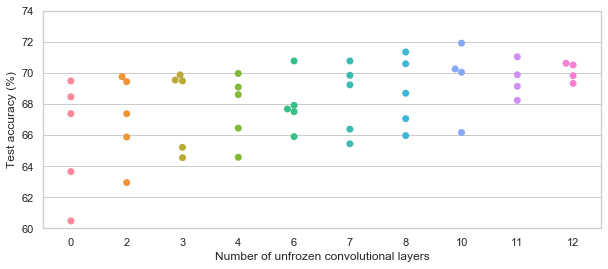

In [39]:
plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
sns.set_palette("Spectral")
# ax = sns.violinplot(data=grad_unfreeze_source_results, width=1)
# ax = sns.boxplot(data=grad_unfreeze_source_results, width=0.5)
# ax = sns.swarmplot(data=grad_unfreeze_source_results, color="0.25")
ax = sns.swarmplot(data=grad_unfreeze_source_results, size=7)
plt.xlabel('Number of unfrozen convolutional layers')
plt.ylabel('Test accuracy (%)')
plt.ylim((60,74))
plt.savefig('gradual-unfreeze-AD.pdf')  

## Tune source and target

In [40]:
# tune_both_scores = get_score_combinations(
#     suffix='tune_target', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191023072318',
#     to_date='20191023123426'
# )*100
# tune_both_scores.describe().T

tune_both_scores = get_score_combinations_new(
    method='tune_target',
    experiment_id='tune_target_with_aug',
)*100
tune_both_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,61.085494,2.378802,57.867906,59.253519,62.271860,62.849498,63.184687
A->D,5.0,71.109888,1.927705,68.264636,70.189142,71.646134,72.267730,73.181796
W->A,5.0,51.463341,1.888107,49.732963,50.064468,51.481689,51.523875,54.513709
W->D,5.0,99.435273,0.441863,98.830645,99.239828,99.429280,99.676611,100.000000
D->A,5.0,53.290147,2.638020,49.818156,52.417746,52.637920,54.760765,56.816146
D->W,5.0,94.504207,2.191412,91.000667,94.408916,94.527924,95.775053,96.808476


### Coarse gradual unfreeze 

In [41]:
tune_target_vgg16_aug = get_score_combinations_new(
    method='tune_target',
    experiment_id='vgg16_aug',
)*100
tune_target_vgg16_aug.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,6.0,67.743384,1.324547,65.995040,66.862630,67.744440,68.565799,69.568102
A->W,5.0,64.154551,2.456410,61.827506,62.573438,62.739617,66.656314,66.975879
D->A,5.0,49.743536,1.869811,48.072355,48.332181,48.787909,51.504346,52.020887
D->W,5.0,95.060522,0.726806,94.082111,94.633431,95.134199,95.525206,95.927664
W->A,5.0,45.623685,0.134786,45.440640,45.542510,45.667938,45.676998,45.790339
W->D,5.0,98.786482,1.145501,97.434716,97.757296,99.047619,99.692780,100.000000


In [42]:
tune_target_vgg16_aug_coarse_grad_ft = get_score_combinations_new(
    method='tune_target',
    experiment_id='vgg16_aug_coarse_grad_ft',
)*100
tune_target_vgg16_aug_coarse_grad_ft.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,71.354832,2.047845,69.217956,69.598614,71.136240,72.852380,73.968967
A->W,5.0,73.989078,4.948449,70.062192,71.046410,71.095686,75.883947,81.857153
D->A,5.0,56.201621,3.611262,53.372360,53.476973,54.126970,58.724620,61.307181
D->W,5.0,95.869260,1.167603,95.146474,95.190651,95.300098,95.804594,97.904483
W->A,5.0,50.226811,2.631192,46.918136,48.885330,49.591069,52.335316,53.404202
W->D,5.0,99.108672,0.806583,97.709293,99.327620,99.354030,99.354030,99.798387


In [43]:
tune_target_resnet101v2_aug = get_score_combinations_new(
    method='tune_target',
    experiment_id='resnet101v2_aug',
)*100
tune_target_resnet101v2_aug.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,6.0,84.254214,1.513708,81.794666,83.811027,84.307415,84.919251,86.347023
A->W,5.0,84.191339,2.686088,80.087920,82.992716,85.060523,86.358046,86.457488
D->A,5.0,61.612857,0.893445,60.666588,60.966469,61.523463,61.975817,62.931950
D->W,5.0,94.691265,0.306723,94.462479,94.498291,94.542370,94.751049,95.202138
W->A,5.0,60.604942,0.381875,60.187240,60.415718,60.548726,60.662655,61.210369
W->D,5.0,98.387678,0.580469,97.440673,98.249685,98.594667,98.784119,98.869245


In [44]:
tune_target_resnet101v2_aug_coarse_grad_ft = get_score_combinations_new(
    method='tune_target',
    experiment_id='resnet101v2_aug_coarse_grad_ft',
)*100
tune_target_resnet101v2_aug_coarse_grad_ft.describe().T.sort_index()

,count,mean,std,min,25%,50%,75%,max
A->D,6.0,86.200014,1.825390,84.220063,85.121348,85.722943,86.918689,89.296046
A->W,5.0,86.637348,1.054278,84.906934,86.629824,86.729457,87.249601,87.670926
D->A,5.0,62.905532,1.268804,61.641015,61.780017,62.662449,64.067289,64.376890
D->W,5.0,94.625185,0.317125,94.348822,94.413338,94.498291,94.738139,95.127337
W->A,5.0,60.932032,0.721214,60.024654,60.404908,61.155426,61.224453,61.850721
W->D,5.0,98.268413,0.487107,97.440673,98.249685,98.422594,98.604908,98.624207


## Multitask

In [45]:
multitask_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_with_batchnorn_alpha_0',
)*100
multitask_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,82.246817,1.969259,78.882510,82.472647,82.696985,83.187111,83.994833
A->D,5.0,81.639897,3.776856,76.464491,79.691296,81.490104,85.267342,85.286252
W->A,5.0,62.787145,1.619392,60.945469,62.246861,62.250118,63.184237,65.309041
W->D,5.0,96.446651,1.856850,94.604878,95.083155,95.933416,97.480295,99.131514
D->A,5.0,62.137225,1.845662,59.026163,62.062513,62.881350,62.906923,63.809178
D->W,5.0,93.151885,1.180425,91.886829,92.282002,92.951599,93.845259,94.793734


In [46]:
multitask_from_feat_scores = get_score_combinations_new(
    method='multitask',
    experiment_id='multitask_from_feat',
)*100
multitask_from_feat_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.951547,1.781932,74.828445,75.725503,77.137986,77.623430,79.442370
A->D,5.0,79.569162,1.884115,77.742799,77.931996,79.101897,81.188341,81.880778
W->A,5.0,61.437911,1.227911,59.755625,61.055036,61.374627,61.875540,63.128726
W->D,5.0,92.880424,1.729158,90.802650,92.096799,92.847842,93.135756,95.519075
D->A,5.0,62.088304,0.695510,61.411388,61.634456,62.008086,62.178494,63.209096
D->W,5.0,91.085036,0.898458,90.040356,90.359053,91.073812,91.869186,92.082773


### Gradual unfreeze Multitask

In [47]:
multitask_grad_unf_0_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_0',
)*100

multitask_grad_unf_2_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_2',
)*100

multitask_grad_unf_3_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_3',
)*100

multitask_grad_unf_4_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_4',
)*100

multitask_grad_unf_6_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_6',
)*100

multitask_grad_unf_7_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_7',
)*100

multitask_grad_unf_8_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_8',
)*100

multitask_grad_unf_10_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_10',
)*100

multitask_grad_unf_11_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_11',
)*100

multitask_grad_unf_12_vgg16 = get_score_combinations_new(
    method='multitask',
    experiment_id='gradual_unfreeze_vgg16_12',
)*100

In [48]:
grad_unfreeze_multitask_results = pd.DataFrame({ 
    '0'  : multitask_grad_unf_0_vgg16['A->D'],
    '2'  : multitask_grad_unf_2_vgg16['A->D'],
    '3'  : multitask_grad_unf_3_vgg16['A->D'],
    '4'  : multitask_grad_unf_4_vgg16['A->D'],
    '6'  : multitask_grad_unf_6_vgg16['A->D'],
    '7'  : multitask_grad_unf_7_vgg16['A->D'],
    '8'  : multitask_grad_unf_8_vgg16['A->D'],
    '10' : multitask_grad_unf_10_vgg16['A->D'],
    '11' : multitask_grad_unf_11_vgg16['A->D'],
    '12' : multitask_grad_unf_12_vgg16['A->D'],
})

grad_unfreeze_multitask_results

,0,2,3,4,6,7,8,10,11,12
0,78.024527,78.430553,77.524106,73.331233,70.985669,69.447498,71.533963,71.648769,73.315471,71.935480
1,81.068635,77.900162,81.996171,73.893275,78.257697,76.541460,75.900779,76.090533,76.631312,78.106639
2,77.154880,76.334323,79.433289,77.898059,79.678513,80.738080,78.359916,79.036734,79.857298,79.524885
3,80.180656,79.523977,79.587907,79.889563,80.040107,82.084151,80.951282,80.722489,83.249402,82.300671
4,82.523403,83.369327,80.236138,84.054525,84.408700,82.282119,81.873688,81.692305,84.355085,83.216825


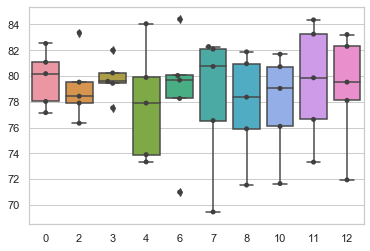

In [49]:
ax = sns.boxplot(data=grad_unfreeze_multitask_results)
ax = sns.swarmplot(data=grad_unfreeze_multitask_results, color=".25")

### From FT-source varying learning rate

In [121]:
multitask_from_source_10neg5 = get_score_combinations_new(
    method='multitask',
    experiment_id='vgg16_from_source_vary_lr',
    config_key='learning_rate',
    config_value=1e-5
)*100
multitask_from_source_10neg5.describe().T

,count,mean,std,min,25%,50%,75%,max
D->A,1.0,65.251775,NaN,65.251775,65.251775,65.251775,65.251775,65.251775


In [122]:
multitask_from_source_10neg6 = get_score_combinations_new(
    method='multitask',
    experiment_id='vgg16_from_source_vary_lr',
    config_key='learning_rate',
    config_value=1e-6
)*100
multitask_from_source_10neg6.describe().T

,count,mean,std,min,25%,50%,75%,max
D->A,1.0,65.052717,NaN,65.052717,65.052717,65.052717,65.052717,65.052717


In [123]:
multitask_from_source_10neg7 = get_score_combinations_new(
    method='multitask',
    experiment_id='vgg16_from_source_vary_lr',
    config_key='learning_rate',
    config_value=1e-7
)*100
multitask_from_source_10neg7.describe().T

,count,mean,std,min,25%,50%,75%,max
D->A,1.0,64.623939,NaN,64.623939,64.623939,64.623939,64.623939,64.623939


### From FT: Straight tuning of all, or gradual
It seems like straight tuning actually performed better!

In [157]:
multitask_from_source_10neg5 = get_score_combinations_new(
    method='multitask',
    experiment_id='vgg16_from_source_vary_lr',
    config_key='learning_rate',
    config_value=1e-5
)*100
multitask_from_source_10neg5.describe().T

,count,mean,std,min,25%,50%,75%,max
D->A,1.0,65.251775,NaN,65.251775,65.251775,65.251775,65.251775,65.251775


In [155]:
multitask_from_source_fe = get_score_combinations_new(
    method='multitask',
    experiment_id='vgg16_grad',
    config_key='learning_rate',
    config_value=1e-5
)*100
multitask_from_source_fe.describe().T

,count,mean,std,min,25%,50%,75%,max
D->A,1.0,60.488994,NaN,60.488994,60.488994,60.488994,60.488994,60.488994


In [156]:
multitask_from_source_grad = get_score_combinations_new(
    method='multitask',
    experiment_id='vgg16_grad_coarse_grad_ft',
    config_key='learning_rate',
    config_value=1e-5
)*100
multitask_from_source_grad.describe().T

,count,mean,std,min,25%,50%,75%,max
D->A,1.0,64.926999,NaN,64.926999,64.926999,64.926999,64.926999,64.926999


## CCSA

__Run 1__: The were some severe stability issues when introducting the CSA loss (alpha 0.25 as done by original author).
Employed parameters:
- alpha=0.01 
- freeze_base=true

In [50]:
# tune_ccsa_scores = get_score_combinations(
#     suffix='ccsa', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191025141713',
#     to_date='20191025170306'
# )*100
# tune_ccsa_scores.describe().T

tune_ccsa_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_without_batchnorn',
)*100
tune_ccsa_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,75.742420,2.675415,73.528201,74.219874,75.028777,75.622616,80.312631
A->D,5.0,78.850891,2.613355,75.617840,77.443585,78.284936,80.742628,82.165464
W->A,5.0,58.724779,1.334933,57.124357,57.473593,59.255185,59.771245,59.999512
W->D,5.0,94.514392,2.757514,90.746226,93.879878,94.020548,95.624368,98.300937
D->A,5.0,58.843418,1.525688,57.434891,57.556489,58.726714,59.326725,61.172271
D->W,5.0,92.247328,2.057693,89.381254,91.461173,91.921079,94.032362,94.440773


We observe a large performance increment for the domain adaptations where domains are far apart. However, for similar domains (W,D)

__Run 3__ multi-task learning (ccsa code with alpha=0)

In [51]:
# multitask_scores = get_score_combinations(
#     suffix='ccsa', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191101173414',
#     to_date='20191101191220'
# )*100
# multitask_scores.describe().T

multitask_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_with_batchnorn_alpha_0',
)*100
multitask_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,82.246817,1.969259,78.882510,82.472647,82.696985,83.187111,83.994833
A->D,5.0,81.639897,3.776856,76.464491,79.691296,81.490104,85.267342,85.286252
W->A,5.0,62.787145,1.619392,60.945469,62.246861,62.250118,63.184237,65.309041
W->D,5.0,96.446651,1.856850,94.604878,95.083155,95.933416,97.480295,99.131514
D->A,5.0,62.137225,1.845662,59.026163,62.062513,62.881350,62.906923,63.809178
D->W,5.0,93.151885,1.180425,91.886829,92.282002,92.951599,93.845259,94.793734


__Run 4__ ccsa with alpha = 0.25

In [52]:
# ccsa_scores = get_score_combinations(
#     suffix='ccsa', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191101150707',
#     to_date='20191101171905'
# )*100
# ccsa_scores.describe().T

ccsa_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_with_batchnorn_alpha_0.25',
)*100
ccsa_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,82.053859,3.184397,77.335652,80.185258,83.807674,84.306638,84.634074
A->D,5.0,83.205464,4.637477,75.562647,82.283594,85.021632,85.991254,87.168190
W->A,5.0,59.942600,2.506962,56.300600,59.420163,60.102220,60.611297,63.278719
W->D,5.0,93.377112,2.410914,89.385241,92.852714,94.500764,94.967452,95.179391
D->A,5.0,60.062680,1.737484,58.366524,58.538364,59.943787,60.930771,62.533956
D->W,5.0,91.662877,2.652035,87.019792,92.299570,92.581867,92.677914,93.735243


In [53]:
# ccsa_uneven_scores = get_score_combinations(
#     suffix='ccsa', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191104152050',
#     to_date='20191104185818'
# )*100
# ccsa_uneven_scores.describe().T

ccsa_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_uneven',
)*100
ccsa_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,83.670829,1.471671,81.734642,83.049615,83.811191,83.988340,85.770358
A->D,5.0,83.948759,3.483476,78.986872,82.301451,84.965537,85.239469,88.250468
W->A,5.0,60.762464,2.894419,57.515891,57.960931,61.930413,62.240837,64.164248
W->D,5.0,93.962099,2.007302,91.302737,92.595005,94.361165,95.308002,96.243587
D->A,5.0,60.748306,2.875684,58.852342,58.905964,60.041313,60.168354,65.773557
D->W,5.0,92.341015,2.160339,89.720092,91.340607,91.577385,93.985261,95.081733


In [54]:
# ccsa_resnet_uneven_scores = get_score_combinations(
#     suffix='ccsa', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191106083058',
#     to_date='20191106144631'
# )*100
# ccsa_resnet_uneven_scores.describe().T

ccsa_resnet_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_resnet_uneven',
)*100
ccsa_resnet_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,87.031006,1.771051,84.948940,86.167361,86.834364,87.486444,89.717922
A->D,6.0,85.063233,2.814971,82.101262,83.276672,84.530207,85.915848,89.981167
W->A,5.0,66.296887,1.863406,64.186964,64.790355,66.280834,67.579330,68.646950
W->D,5.0,93.213288,1.588620,90.456151,93.378977,93.692998,94.215515,94.322798
D->A,6.0,63.348348,3.895106,56.421669,62.158136,64.412479,65.836007,67.126254
D->W,5.0,91.869634,1.176867,90.626558,90.736290,91.941837,92.862937,93.180548


### CCSA from features
Testing if batch size has an impact on CCSA (like seems to have on DAGE)

In [55]:
ccsa_from_feat_batch_size_16_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_batch_size',
    config_key='batch_size',
    config_value=16,
)*100
ccsa_from_feat_batch_size_16_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,78.692936,2.095097,76.239832,77.533565,77.922968,80.876784,80.891532
A->D,5.0,79.934687,2.012026,76.915229,78.865077,80.901390,81.248170,81.743571
W->A,5.0,59.593263,0.700040,58.823768,59.173603,59.397356,59.974019,60.597570
W->D,5.0,90.720244,2.132680,88.604330,89.241836,90.116630,91.734123,93.904301
D->A,5.0,58.754116,2.014040,56.616574,57.279330,58.113146,60.768443,60.993086
D->W,5.0,89.419089,1.367894,88.172059,88.231145,89.386347,89.794941,91.510954


In [56]:
ccsa_from_feat_batch_size_32_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_batch_size',
    config_key='batch_size',
    config_value=32,
)*100
ccsa_from_feat_batch_size_32_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,78.702377,1.076480,77.478952,77.866104,78.950808,79.000948,80.215075
A->D,5.0,80.234521,1.410094,78.889264,79.124906,80.235829,80.485979,82.436627
W->A,5.0,59.483516,1.262914,58.336383,58.574381,59.215049,59.790580,61.501188
W->D,5.0,90.622727,1.728368,88.671119,88.872740,91.480989,91.657794,92.430991
D->A,5.0,59.186099,1.857309,55.969808,59.308094,59.814438,60.376145,60.462012
D->W,5.0,89.943420,1.276624,88.648308,88.870440,89.694914,90.931238,91.572202


In [57]:
ccsa_from_feat_batch_size_64_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_batch_size',
    avg_types=['macro avg'],
    config_key='batch_size',
    config_value=64,
)*100
ccsa_from_feat_batch_size_64_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,77.543899,0.888589,76.600254,77.293748,77.402157,77.407494,79.015844
A->D,5.0,79.905941,2.311817,76.233360,79.062971,81.043057,81.295497,81.894820
W->A,5.0,58.339270,2.180111,55.979379,56.024600,59.167922,60.226239,60.298209
W->D,5.0,88.895125,2.073848,87.271577,87.293069,87.632191,90.731713,91.547075
D->A,5.0,58.092224,1.891676,55.229602,57.677990,58.405702,58.719954,60.427872
D->W,5.0,89.568278,0.987218,88.248991,88.839339,89.927026,90.225049,90.600983


In [58]:
ccsa_from_feat_batch_size_128_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_batch_size',
    config_key='batch_size',
    config_value=128,
)*100
ccsa_from_feat_batch_size_128_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,77.802341,2.192326,74.396191,77.406221,78.275036,78.545189,80.389066
A->D,5.0,77.937598,3.037692,75.570180,75.684774,76.209883,79.867165,82.355988
W->A,5.0,57.993967,1.990706,55.956193,56.028545,58.122237,59.536291,60.326567
W->D,5.0,88.451026,1.416326,86.469129,87.606385,88.777507,89.426427,89.975684
D->A,5.0,57.948127,1.058596,56.361534,57.398620,58.390980,58.665119,58.924381
D->W,5.0,87.313234,3.200792,84.076167,85.685335,86.166547,88.261548,92.376574


In [59]:
ccsa_from_feat_batch_size_256_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_batch_size',
    config_key='batch_size',
    config_value=256,
)*100
ccsa_from_feat_batch_size_256_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,10.0,76.418088,2.203766,72.621001,75.640955,76.712300,78.223569,78.944387
A->D,10.0,79.028324,1.649357,76.763159,77.621086,79.152865,79.814023,82.113664
W->A,10.0,53.884818,3.405288,47.417322,52.126323,54.070697,56.745459,58.431349
W->D,10.0,87.415946,3.283987,83.218095,84.675465,86.720421,89.755392,92.803057
D->A,10.0,55.701392,2.456918,51.558282,54.307595,56.126291,57.516012,58.684065
D->W,10.0,83.872707,3.717283,77.530400,81.862186,84.691625,85.631380,89.819211


In [60]:
ccsa_from_feat_batch_size_4096_uneven_scores = get_score_combinations_new(
    method='ccsa',
    experiment_id='ccsa_batch_size',
    config_key='batch_size',
    config_value=4096,
)*100
ccsa_from_feat_batch_size_4096_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,71.788325,3.020006,66.596201,71.974178,72.763199,73.349835,74.258215
A->D,5.0,69.300909,5.707335,61.496660,66.568417,69.751172,72.014922,76.673376
W->A,5.0,50.151572,3.041810,47.522959,47.843419,49.189533,51.305174,54.896773
W->D,5.0,80.501625,2.797813,77.081681,78.591449,80.516066,82.200871,84.118060
D->A,5.0,48.566075,5.086495,42.007389,45.702089,47.824992,53.459842,53.836064
D->W,5.0,79.280523,5.655613,71.966006,74.828236,81.732519,82.321799,85.554052


### Flip test
Using CCSA with alpha=0.25, FE VGG16, adam, lr=1e-4, batch size=16

In [61]:
# regular training setup with even weighting of source and target cross entropies, without the learning rate reduction and early stopping callbacks
# this test was done to check if these callbacks caused the degraded performance
ccsa_flip_test_regular_even_no_cb = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_regular_0.5_no_cb',
)*100
ccsa_flip_test_regular_even_no_cb.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,56.182692,2.958603,52.512791,53.834522,56.996215,57.829515,59.740416


In [62]:
# regular training setup with even weighting of source and target cross entropies
ccsa_flip_test_regular_even = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_regular',
)*100
ccsa_flip_test_regular_even.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,57.120339,1.833822,53.94533,57.26043,57.699354,58.335678,58.360902


In [63]:
# regular training setup with weighting target cross entropies only
ccsa_flip_test_regular_target_only = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_regular_1',
)*100
ccsa_flip_test_regular_target_only.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,59.08347,0.519087,58.269562,58.864528,59.343506,59.445553,59.4942


In [64]:
# regular training setup with weighting source cross entropies only
ccsa_flip_test_regular_source_only = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_regular_0',
)*100
ccsa_flip_test_regular_source_only.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,38.620661,6.504629,29.601376,36.216851,37.525231,43.748925,46.01092


In [65]:
# train a batch, flip source and target, the train on the same batch again. Here, we accidentally used an even weighting for source and target ce
ccsa_flip_test_flipping_both = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_flipping',
)*100
ccsa_flip_test_flipping_both.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,59.8992,1.889428,57.977127,58.4476,59.442577,61.130913,62.497782


In [66]:
# train a batch, flip source and target, the train on the same batch again. Here, we only weight the ce from the first branch
ccsa_flip_test_flipping_one = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_flipping_0',
)*100
ccsa_flip_test_flipping_one.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,58.602653,1.842668,56.532795,56.857532,58.908489,60.331202,60.383249


In [67]:
# train a batch, the train on the same batch again (no flipping). Here, we weight the ce losses evenly
# this should be equal to the "ccsa_flip_test_flipping_both" run above
ccsa_flip_test_repeat_batch_2_even = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_repeat_batch_0.5',
)*100
ccsa_flip_test_repeat_batch_2_even.describe().T


,count,mean,std,min,25%,50%,75%,max
W->A,5.0,59.250448,0.587495,58.696804,58.919614,59.076594,59.346966,60.212264


In [90]:
# train a batch, flip source and target, the train on the same batch again. Here, weight only one branch. We test an optimized implementation here
ccsa_flip_test_v2_source_only = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_0_v2',
)*100
ccsa_flip_test_v2_source_only.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,6.0,59.485523,1.225376,58.467443,58.557451,58.991347,60.219601,61.421165


In [91]:
# train a batch, flip source and target, the train on the same batch again. Here, weight both branches equally. We test an optimized implementation here
ccsa_flip_test_v2_even = get_score_combinations_new(
    method='ccsa',
    experiment_id='flip_test_0.5_v2',
)*100
ccsa_flip_test_v2_even.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,60.196115,1.03347,58.605917,59.783347,60.468873,61.030215,61.092225


In [604]:
pd.concat([
    present(ccsa_flip_test_regular_even, 'No flip'),
    present(ccsa_flip_test_flipping_one, 'Flip, batch repeat'),
    present(ccsa_flip_test_v2_even, 'No flip, batch repeat'),
])    

,W->A,mean
No flip,57.12 ±1.83,57.1203
"Flip, batch repeat",58.60 ±1.84,58.6027
"No flip, batch repeat",60.20 ±1.03,60.1961


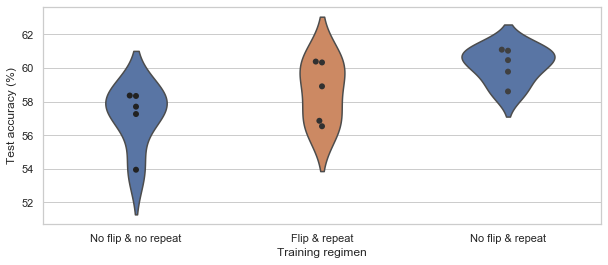

In [628]:
def get_batch_size_results(datasets='W->A'):
    def mod(df, method:str, column=datasets):
        df = df[column].rename('acc').to_frame()
        df['Method'] = method
        return df

    results = pd.concat([
        mod(ccsa_flip_test_regular_even, 'No flip & no repeat'),
        mod(ccsa_flip_test_flipping_one, 'Flip & repeat'),
        mod(ccsa_flip_test_v2_even, 'No flip & repeat'),
    ])    
    return results

res = get_batch_size_results()

plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette("Set2")
ax = sns.violinplot(x='Method', y='acc', hue=None, data=res, width=0.5, inner=None, palette=sns.color_palette(None, 2))
ax = sns.swarmplot(x='Method', y='acc', hue='Method', data=res, size=6, color='0.25')
plt.xlabel('Training regimen')
plt.ylabel('Test accuracy (%)')
ax.get_legend().remove()
plt.savefig('flip-experiment-violin-WA.pdf') 

### Batch repeat experiments
It seems like simply repeating a batch twice is better than doing the flipping.
Here, we test if using even more repeats is helpfull

Using CCSA with alpha=0.25, FE VGG16, adam, lr=1e-4, batch size=16

In [129]:
ccsa_batch_repeat_1 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_1',
)*100
ccsa_batch_repeat_1.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,58.071556,1.702833,55.90954,56.525195,58.133948,58.976027,60.813557


In [130]:
ccsa_batch_repeat_2 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_2',
)*100
ccsa_batch_repeat_2.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,60.091863,1.240636,57.82751,59.640544,59.877626,60.390899,62.508862


In [131]:
ccsa_batch_repeat_3 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_3',
)*100
ccsa_batch_repeat_3.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,60.543938,1.3893,57.898631,59.801906,60.573028,61.586225,62.283153


In [132]:
ccsa_batch_repeat_4 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_4',
)*100
ccsa_batch_repeat_4.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,59.586337,1.252654,58.040551,58.583682,59.167775,60.821302,61.38946


In [133]:
ccsa_batch_repeat_5 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_5',
)*100
ccsa_batch_repeat_5.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,59.671694,1.065709,58.170005,58.941079,59.568249,60.360456,61.189369


In [134]:
ccsa_batch_repeat_10 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_repeat_10',
)*100
ccsa_batch_repeat_10.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,10.0,59.708881,1.33977,57.214923,58.961334,59.617865,60.803057,61.412026


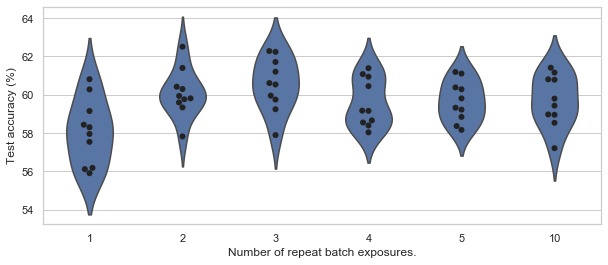

In [626]:
def mod(df, repeats:float, method:str, column='W->A'):
    df = df[column].rename('acc').to_frame()
    df['repeats'] = repeats
    df['method'] = method
    df
    return df

batch_repeat_results = pd.concat([
    mod(ccsa_batch_repeat_1, 1, 'ccsa'),
    mod(ccsa_batch_repeat_2, 2, 'ccsa'),
    mod(ccsa_batch_repeat_3, 3, 'ccsa'),
    mod(ccsa_batch_repeat_4, 4, 'ccsa'),
    mod(ccsa_batch_repeat_5, 5, 'ccsa'),
    mod(ccsa_batch_repeat_10, 10, 'ccsa'),
])

plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette("Set2")
ax = sns.violinplot(x='repeats', y='acc', hue='method',  data=batch_repeat_results, width=0.5, inner=None)
ax = sns.swarmplot(x='repeats', y='acc', hue='method', data=batch_repeat_results, size=6, color='0.25')
plt.xlabel('Number of repeat batch exposures.')
plt.ylabel('Test accuracy (%)')
# plt.legend(loc='upper right')
ax.get_legend().remove()
plt.savefig('batch-repeat-WA.pdf') 

### Alpha search light
FE VGG16, adam, lr=1e-4, even loss weighting, regular training

In [264]:
multitask_light = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0,
)*100
multitask_light.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.826552,2.242702,77.403137,78.595673,78.842248,81.437433,82.854268
W->A,5.0,62.112996,1.068584,60.866602,61.267599,62.342640,62.537725,63.550412


In [265]:
ccsa_alpha_search_light005 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.05,
)*100
ccsa_alpha_search_light005.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,62.288967,0.906074,61.419358,61.544722,62.079112,62.835602,63.566039


In [266]:
ccsa_alpha_search_light01 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.1,
)*100
ccsa_alpha_search_light01.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.409309,0.860050,79.473432,79.960940,80.278793,80.567709,81.765672
W->A,5.0,61.443243,0.424543,60.856024,61.266003,61.415474,61.716641,61.962076


In [267]:
ccsa_alpha_search_light025 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.25,
)*100
ccsa_alpha_search_light025.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.134343,3.229596,74.323845,78.694226,79.005656,80.427290,83.220698
W->A,5.0,57.554486,2.154422,54.883009,56.433084,57.160519,58.856791,60.439029


In [268]:
ccsa_alpha_search_light05 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.5,
)*100
ccsa_alpha_search_light05.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,58.395793,3.288602,55.207917,55.804034,57.890245,59.753379,63.323392
W->A,5.0,32.552409,3.194693,28.485366,31.661489,32.394323,32.832533,37.388337


In [269]:
ccsa_alpha_search_light075 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.75,
)*100
ccsa_alpha_search_light075.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,28.089171,2.304633,24.090007,28.152808,29.165656,29.486330,29.551054
W->A,5.0,17.954809,2.601132,13.507745,17.908602,18.926017,19.451885,19.979794


In [270]:
ccsa_alpha_search_light09 = get_score_combinations_new(
    method='ccsa',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.9,
)*100
ccsa_alpha_search_light09.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,25.893177,5.557179,16.400275,27.021397,27.294982,27.651973,31.097259
W->A,5.0,15.964302,1.663536,14.463343,15.115335,15.251589,16.291889,18.699356


### Batch size
FE VGG16, adam, even loss weighting, regular training, alpha=0.1

In [405]:
ccsa_bs_16 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 16,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_64 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_256 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_1024 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 1e-4
    },
)*100
ccsa_bs_4096 = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 1e-4
    },
)*100

In [448]:
ccsa_bs_64_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 2e-4
    },
)*100
ccsa_bs_256_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 4e-4
    },
)*100
ccsa_bs_1024_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 8e-4
    },
)*100
ccsa_bs_4096_comp = get_score_combinations_new(
    method='ccsa',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 16e-4
    },
)*100

## d-SNE

In [76]:
# dsne_scores = get_score_combinations(
#     suffix='dsne', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191104094606',
#     to_date='20191104124943'
# )*100
# dsne_scores.describe().T

dsne_scores = get_score_combinations_new(
    method='dsne',
    experiment_id='dsne_even',
    config_dict = 
)*100
dsne_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,82.637789,3.750343,76.179228,83.176060,83.394605,84.798776,85.640273
A->D,5.0,82.899062,2.343457,79.169803,82.774942,83.120798,83.877983,85.551784
W->A,5.0,61.244879,2.007790,58.961683,60.204127,61.095395,61.607912,64.355279
W->D,5.0,94.250473,2.413102,90.343298,93.698415,95.069887,95.608934,96.531832
D->A,5.0,61.144240,1.821195,58.882238,60.581306,60.827800,61.531882,63.897976
D->W,5.0,93.185104,1.206807,91.849076,91.947896,93.598691,94.206681,94.323173


In [77]:
# dsne_uneven_scores = get_score_combinations(
#     suffix='dsne', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191104152038',
#     to_date='20191104182550'
# )*100
# dsne_uneven_scores.describe().T

dsne_uneven_scores = get_score_combinations_new(
    method='dsne',
    experiment_id='dsne_uneven',
)*100
dsne_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.535694,3.937966,74.259330,77.341222,79.519223,82.459460,84.099234
A->D,5.0,82.616963,4.815117,75.793566,80.096973,83.320112,85.934324,87.939840
W->A,5.0,60.874277,0.865832,59.805571,60.379551,60.880408,61.206196,62.099660
W->D,5.0,87.983768,4.247609,82.052288,86.906604,87.357056,90.028895,93.573998
D->A,5.0,59.691342,0.753146,58.576855,59.562061,59.734691,59.912254,60.670851
D->W,5.0,90.453001,1.057310,89.084983,90.184278,90.289976,90.688887,92.016879


In [78]:
# dsne_large_uneven_scores = get_score_combinations(
#     suffix='dsne', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191105120356',
#     to_date='20191105154214'
# )*100
# dsne_large_uneven_scores.describe().T

dsne_large_uneven_scores = get_score_combinations_new(
    method='dsne',
    experiment_id='dsne_uneven_large',
)*100
dsne_large_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.970975,1.768348,77.444464,78.876506,80.579156,81.380595,81.574153
A->D,5.0,81.419812,3.463785,76.657367,80.013335,81.982101,82.312784,86.133473
W->A,5.0,58.276692,2.063213,55.534978,56.585731,59.595527,59.655118,60.012106
W->D,5.0,90.606777,1.923527,88.210733,89.164284,90.714528,92.412935,92.531406
D->A,5.0,58.434207,2.500953,56.185736,56.369373,57.447654,60.500023,61.668249
D->W,5.0,89.096329,2.365982,86.015564,87.882513,88.852307,90.634875,92.096386


In [79]:
# dsne_resnet_uneven_scores = get_score_combinations(
#     suffix='dsne', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191107085855',
#     to_date='20191107131237'
# )*100
# dsne_resnet_uneven_scores.describe().T


dsne_resnet_uneven_scores = get_score_combinations_new(
    method='dsne',
    experiment_id='dsne_uneven_resnet',
)*100
dsne_resnet_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,84.481638,1.296053,83.108895,83.791110,83.796457,85.619960,86.091765
A->D,5.0,85.564002,2.761330,83.675441,84.356927,84.525317,84.815943,90.446381
W->A,5.0,64.672335,2.645949,60.945438,64.342418,64.516566,65.180442,68.376812
W->D,5.0,90.474503,2.026937,88.179186,88.503613,91.083311,91.969984,92.636423
D->A,5.0,64.588399,1.548332,63.212242,63.429294,64.412023,64.794350,67.094087
D->W,5.0,89.471782,0.905457,88.008139,89.332898,89.713810,89.893366,90.410696


### d-SNE from features

In [80]:
dsne_from_feat_batch_size_16_uneven_scores = get_score_combinations_new(
    method='dsne',
    experiment_id='dsne_from_features',
)*100
dsne_from_feat_batch_size_16_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.803022,1.164494,75.193858,76.217500,76.894501,77.485954,78.223295
A->D,6.0,79.254324,1.546634,77.823398,78.329229,79.001573,79.316170,82.173248
W->A,5.0,58.603961,1.029454,57.217158,58.128567,58.662092,59.026839,59.985146
W->D,5.0,90.376749,2.789147,86.937440,88.892264,89.734160,92.391964,93.927919
D->A,5.0,58.271300,1.351152,56.382412,57.466985,58.628672,59.098727,59.779703
D->W,5.0,84.316095,0.976567,83.445324,83.634220,83.755717,85.222475,85.522739


### Alpha search light
FE VGG16, adam, lr=1e-4, even loss weighting, regular training

In [271]:
dsne_alpha_search_light005 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.05,
)*100
dsne_alpha_search_light005.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,62.135216,0.680315,61.244821,61.693374,62.192311,62.619435,62.926137


In [272]:
dsne_alpha_search_light01 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.1,
)*100
dsne_alpha_search_light01.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.368500,1.398707,79.158679,79.634119,79.925686,80.383548,82.740469
W->A,5.0,61.498817,1.006403,60.414948,60.767062,61.533149,61.775678,63.003251


In [273]:
dsne_alpha_search_light025 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.25,
)*100
dsne_alpha_search_light025.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.559941,1.595350,78.611114,79.321343,80.804848,81.551967,82.510433
W->A,5.0,61.367479,1.965252,58.660601,60.734580,61.065922,62.480853,63.895437


In [274]:
dsne_alpha_search_light05 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.5,
)*100
dsne_alpha_search_light05.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.904192,1.274271,79.494130,79.694081,81.196612,81.716147,82.419991
W->A,5.0,59.946678,0.338412,59.562761,59.618146,60.046430,60.202458,60.303597


In [275]:
dsne_alpha_search_light075 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.75,
)*100
dsne_alpha_search_light075.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.85709,2.214712,76.821830,78.208415,81.100647,81.242357,81.912200
W->A,5.0,53.35842,2.606840,50.069184,52.004812,52.707790,55.784495,56.225818


In [276]:
dsne_alpha_search_light09 = get_score_combinations_new(
    method='dsne',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.9,
)*100
dsne_alpha_search_light09.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,78.955045,2.647625,76.156565,77.780654,78.432462,79.147128,83.258417
W->A,5.0,43.916090,3.007585,39.148697,43.453899,44.005703,46.378974,46.593176


## DAGE

In [181]:
# dage_resnet_uneven_scores = get_score_combinations(
#     suffix='homebrew', 
#     domains=['A','W','D'], 
#     avg_types=['macro avg'],
#     from_date='20191113093959',
#     to_date='20191113143542'
# )*100
# dage_resnet_uneven_scores.describe().T

dage_resnet_uneven_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_uneven_resnet',
)*100
dage_resnet_uneven_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,86.793310,2.030049,83.678428,85.869595,87.707500,88.029969,88.681057
A->D,5.0,88.148002,3.357420,84.525758,85.072596,88.226161,90.912142,92.003352
W->A,5.0,62.958609,3.458791,57.568316,62.006779,63.380379,65.611770,66.225801
W->D,5.0,89.377671,3.643778,85.587153,86.556108,89.751572,90.132234,94.861290
D->A,5.0,61.925016,3.388711,55.964133,62.626254,63.133403,63.602036,64.299253
D->W,5.0,87.463632,1.947895,84.439079,86.771515,88.064353,88.612459,89.430753


### DAGE on logits
Varying batch_size

In [182]:
dage_logits_bs_16_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_logits_batch_size',
    config_key='batch_size',
    config_value=16,
)*100
dage_logits_bs_16_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,4.0,77.914269,1.690998,75.689507,77.084809,78.245055,79.074515,79.477460
A->D,5.0,79.701135,2.098469,76.451892,78.804773,80.511487,81.237233,81.500292
W->A,5.0,57.739026,1.417946,56.238515,56.403925,58.024116,58.433597,59.594975
W->D,5.0,84.871494,3.767228,79.725796,83.655947,83.870304,87.958072,89.147348
D->A,5.0,58.726299,2.006272,56.354250,56.869998,59.319172,60.359389,60.728685
D->W,5.0,82.467129,2.600376,78.279420,82.133344,82.850120,83.949347,85.123415


In [183]:
dage_logits_bs_64_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_logits_batch_size',
    config_key='batch_size',
    config_value=64,
)*100
dage_logits_bs_64_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,78.152707,0.915581,76.909879,77.681014,78.148912,78.777648,79.246084
A->D,5.0,79.398941,2.970744,74.908126,78.982066,79.346664,80.726380,83.031467
W->A,5.0,58.139333,1.764337,56.466501,56.646993,57.597263,59.632108,60.353802
W->D,5.0,82.184090,2.382331,79.929144,80.856830,81.745914,82.247250,86.141314
D->A,5.0,56.940367,1.455030,54.386174,57.153622,57.510890,57.769059,57.882089
D->W,5.0,78.370998,2.559597,75.548093,76.998561,77.881021,79.110909,82.316404


In [184]:
dage_logits_bs_256_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_logits_batch_size',
    config_key='batch_size',
    config_value=256,
)*100
dage_logits_bs_256_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,75.816987,1.427608,74.543348,74.793947,75.006765,77.352708,77.388165
A->D,5.0,79.643048,1.455067,78.070060,78.179190,79.965155,80.822867,81.177970
W->A,5.0,56.848319,2.901268,51.676091,57.900379,57.925049,58.269884,58.470190
W->D,5.0,79.113444,1.627555,77.305820,78.339236,78.553457,79.824193,81.544512
D->A,5.0,56.175512,0.704192,54.983380,56.194363,56.304999,56.681698,56.713121
D->W,5.0,75.121371,1.657092,72.682898,74.156601,75.952334,76.175045,76.639977


In [185]:
dage_logits_bs_1024_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_logits_batch_size',
    config_key='batch_size',
    config_value=1024,
)*100
dage_logits_bs_1024_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,73.307227,3.316163,67.724283,73.486295,73.865323,75.124241,76.335992
A->D,5.0,77.857860,2.704332,74.252928,75.975248,78.762593,79.314325,80.984207
W->A,5.0,56.389432,2.308255,52.710413,55.951725,57.085603,57.308936,58.890482
W->D,5.0,76.800753,4.060622,70.710387,75.416153,77.338916,79.129927,81.408382
D->A,5.0,55.575648,2.939502,50.982716,54.738271,56.205837,57.324262,58.627153
D->W,5.0,74.272805,1.684287,71.903676,73.660370,74.300794,75.043603,76.455584


In [186]:
dage_logits_bs_full_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_logits_batch_size',
    config_key='batch_size',
    config_value=4096,
)*100
dage_logits_bs_full_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,73.651178,2.196646,70.710088,72.192024,73.944420,75.671994,75.737366
A->D,5.0,74.744187,3.690587,68.559017,74.750106,75.467498,76.832417,78.111898
W->A,5.0,55.603167,1.661904,53.581453,54.801854,55.448249,56.127724,58.056553
W->D,5.0,76.255471,1.867360,74.778074,74.792937,75.349952,77.337740,79.018650
D->A,5.0,55.027107,3.134399,50.254119,53.555847,56.306370,57.068150,57.951049
D->W,5.0,72.964178,1.987015,69.853205,72.522893,73.093767,74.524004,74.827022


### DAGE full on embeds
Varying batch_size

In [187]:
dage_embeds_bs_8_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_embeds_batch_size',
    config_key='batch_size',
    config_value=8,
)*100
dage_embeds_bs_8_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.109729,1.218604,77.317770,78.631662,79.299888,79.761567,80.537756
A->D,5.0,80.733250,0.981023,79.745691,79.847889,80.922401,81.010699,82.139569
W->A,5.0,58.499030,0.704345,57.634143,58.120527,58.315290,59.069421,59.355771
W->D,5.0,83.799244,4.759352,77.607852,80.097447,85.349931,87.144122,88.796870
D->A,5.0,58.898129,1.442239,57.883687,58.084949,58.348579,58.763389,61.410041
D->W,5.0,84.331256,1.099272,83.356844,83.565864,83.939746,84.735945,86.057883


In [188]:
dage_embeds_bs_16_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_embeds_batch_size',
    config_key='batch_size',
    config_value=16,
)*100
dage_embeds_bs_16_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.172725,0.885765,78.268005,78.645047,78.717609,79.953883,80.279079
A->D,5.0,81.752044,2.481512,77.922407,80.974472,82.429700,82.948395,84.485246
W->A,5.0,58.819161,1.025264,57.342350,58.549466,58.668659,59.513711,60.021621
W->D,5.0,86.383892,2.433609,83.280780,85.633627,85.792492,87.327644,89.884919
D->A,5.0,58.173089,2.185139,56.137563,56.253516,57.514883,60.166148,60.793333
D->W,5.0,85.669846,2.429998,81.517911,85.750240,86.312079,87.182024,87.586976


In [189]:
dage_embeds_bs_32_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_embeds_batch_size',
    config_key='batch_size',
    config_value=32,
)*100
dage_embeds_bs_32_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.720379,1.933291,73.968195,75.615225,77.372129,77.779160,78.867185
A->D,5.0,81.416047,1.582052,80.110915,80.377610,81.104227,81.400786,84.086697
W->A,5.0,57.194000,1.757097,54.962461,55.616355,58.302234,58.494040,58.594909
W->D,5.0,82.372986,2.758186,77.657575,82.226707,83.615305,83.981954,84.383389
D->A,5.0,58.040405,1.283248,56.399276,57.530577,57.586104,59.213418,59.472649
D->W,5.0,81.943302,3.552366,78.135397,80.357863,81.174508,82.389369,87.659372


In [190]:
dage_embeds_bs_64_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_embeds_batch_size',
    config_key='batch_size',
    config_value=64,
)*100
dage_embeds_bs_64_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.104137,2.219537,72.482055,75.948810,76.291978,77.694007,78.103836
A->D,5.0,80.242694,1.457713,78.955302,79.407704,79.699070,80.504296,82.647097
W->A,5.0,57.241031,1.594502,55.162285,55.979419,57.943198,58.183409,58.936845
W->D,5.0,80.649449,1.820345,78.694576,79.305986,80.783927,81.090080,83.372675
D->A,5.0,57.926093,0.909793,56.727799,57.552789,57.791111,58.417996,59.140771
D->W,5.0,78.670539,3.032574,73.643315,78.810179,79.009726,80.225526,81.663950


In [191]:
dage_embeds_bs_128_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_embeds_batch_size',
    config_key='batch_size',
    config_value=128,
)*100
dage_embeds_bs_128_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.123331,0.887455,75.219734,75.297544,76.301848,76.441912,77.355618
A->D,5.0,80.487133,2.059464,78.014454,78.668795,80.984957,82.156674,82.610783
W->A,5.0,56.862097,1.328502,55.599128,55.905234,56.622327,57.235544,58.948251
W->D,5.0,79.406991,4.519759,72.481279,77.960950,80.110167,82.303629,84.178929
D->A,5.0,56.362232,2.190824,53.735583,54.483389,57.204720,57.371872,59.015598
D->W,5.0,75.987273,1.664640,74.001947,75.437579,75.806363,76.096328,78.594149


In [192]:
dage_embeds_bs_full_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_embeds_batch_size',
    config_key='batch_size',
    config_value=4096,
)*100
dage_embeds_bs_full_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,72.481119,1.143141,71.302896,71.413027,72.456928,73.371558,73.861186
A->D,5.0,75.828886,1.469774,74.165814,74.683595,75.870725,76.605987,77.818308
W->A,5.0,56.563554,1.595694,54.022240,56.092062,57.203782,57.375734,58.123953
W->D,5.0,76.390296,2.326356,73.596370,75.188154,76.074130,77.321886,79.770939
D->A,5.0,56.453007,1.431699,54.238029,55.907167,56.868067,57.436927,57.814847
D->W,5.0,74.091168,2.183712,70.560346,73.544247,74.874942,75.371307,76.104997


### DAGE full across on embeds
Varying loss alpha

In [193]:
dage_embeds_full_across_025_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_full_across_alpha',
    config_key='loss_alpha',
    config_value=0.25,
)*100
dage_embeds_full_across_025_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.354982,0.952852,75.399309,75.887439,76.210091,76.348677,77.929392
A->D,5.0,79.596719,2.020705,77.205588,78.645024,79.445365,80.005489,82.682129
W->A,5.0,57.187607,0.978481,55.853930,56.705356,57.236642,57.713927,58.428181
W->D,5.0,79.393194,2.223068,75.915911,78.492177,80.292076,81.090251,81.175556
D->A,5.0,57.065484,1.565760,54.709626,56.545579,57.381439,57.793157,58.897616
D->W,5.0,78.640105,2.544411,75.846149,76.713160,78.075078,81.074477,81.491661


In [194]:
dage_embeds_full_across_05_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_full_across_alpha',
    config_key='loss_alpha',
    config_value=0.5,
)*100
dage_embeds_full_across_05_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,77.033705,1.349857,75.276966,76.212592,76.967829,78.234935,78.476204
A->D,5.0,81.766581,1.627021,79.351521,80.901605,82.454506,82.766566,83.358710
W->A,5.0,57.990955,1.259894,55.828691,58.050564,58.468703,58.556443,59.050375
W->D,5.0,85.107446,2.835490,82.546925,83.830185,84.193825,85.049044,89.917253
D->A,5.0,57.485907,1.543792,55.776128,56.670094,56.745925,58.938804,59.298583
D->W,5.0,82.555612,1.860955,79.535196,82.356787,82.776395,83.784599,84.325080


In [195]:
dage_embeds_full_across_075_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_full_across_alpha',
    config_key='loss_alpha',
    config_value=0.75,
)*100
dage_embeds_full_across_075_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.145492,1.668811,76.941169,77.828437,79.818410,80.434873,80.704569
A->D,5.0,81.467539,1.357990,79.682711,80.554381,81.790834,82.189593,83.120174
W->A,5.0,59.355355,1.587582,57.300308,58.205828,59.605326,60.598453,61.066861
W->D,5.0,86.468388,2.491682,82.190766,86.872858,86.940258,87.741686,88.596375
D->A,5.0,60.106439,1.283992,58.474402,59.668030,59.858979,60.561401,61.969385
D->W,5.0,85.667925,4.281675,79.073171,85.167486,85.356955,88.354284,90.387727


### DAGE pair across on embeds
Varying loss alpha

In [196]:
dage_embeds_pair_across_025_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_pair_across_alpha',
    config_key='loss_alpha',
    config_value=0.25,
)*100
dage_embeds_pair_across_025_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.589065,1.107673,78.417807,78.439160,80.071629,80.127227,80.889505
A->D,5.0,82.065579,1.608317,79.359507,82.211000,82.389747,82.738423,83.629217
W->A,5.0,59.720768,3.582578,53.521531,59.817596,61.347214,61.614436,62.303062
W->D,5.0,90.483844,1.847964,88.002136,90.143117,90.147007,90.995544,93.131414
D->A,5.0,58.829953,1.528216,57.277293,57.756342,58.929917,58.957928,61.228288
D->W,5.0,88.696940,2.971520,83.958316,88.233279,89.136715,90.331189,91.825201


In [197]:
dage_embeds_pair_across_05_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_pair_across_alpha',
    config_key='loss_alpha',
    config_value=0.5,
)*100
dage_embeds_pair_across_05_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.731975,1.927070,77.197408,78.589831,80.240880,80.354264,82.277489
A->D,5.0,81.464172,1.386018,79.884414,80.039801,82.162911,82.533015,82.700719
W->A,5.0,60.252375,1.940745,57.316723,59.714946,60.258505,61.712739,62.258960
W->D,5.0,90.956215,3.187288,86.211817,90.653892,90.937569,91.875642,95.102155
D->A,5.0,60.713363,2.567598,57.168676,59.962433,60.375642,61.936058,64.124008
D->W,5.0,88.917725,2.164269,86.282187,87.511638,88.640795,90.623435,91.530570


In [198]:
dage_embeds_pair_across_075_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_pair_across_alpha',
    config_key='loss_alpha',
    config_value=0.75,
)*100
dage_embeds_pair_across_075_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.372064,1.057996,78.219791,78.685657,79.440436,79.513289,81.001149
A->D,5.0,81.140276,2.828747,78.044509,78.137182,82.517697,83.075789,83.926205
W->A,5.0,61.880156,0.403375,61.282988,61.779303,61.959887,61.981259,62.397345
W->D,5.0,92.065302,0.866511,91.204938,91.303939,91.899175,92.789443,93.129015
D->A,5.0,60.365807,1.653012,58.781338,59.097068,59.936255,61.220804,62.793568
D->W,5.0,90.679537,1.314936,89.652694,89.750646,89.877548,91.532436,92.584361


### DAGE MFA-like
Varying k

In [199]:
dage_embeds_across_knn_knn_1_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_mfa',
    config_key='connection_filter_param',
    config_value=1,
)*100
dage_embeds_across_knn_knn_1_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,79.956112,1.631750,78.170299,79.129339,79.180643,81.182732,82.117546
A->D,5.0,83.546306,0.963445,82.554010,82.577253,83.778608,84.064111,84.757548
W->A,5.0,61.682078,0.630504,61.009277,61.106359,61.774990,62.005240,62.514522
W->D,5.0,92.037668,1.087029,90.818979,90.968031,92.328666,92.941838,93.130828
D->A,5.0,61.559702,1.936285,59.649758,59.781604,61.584927,62.531309,64.250914
D->W,5.0,90.861071,1.307484,89.211441,90.206866,90.780610,91.405193,92.701247


In [200]:
dage_embeds_across_knn_knn_2_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_mfa',
    config_key='connection_filter_param',
    config_value=2,
)*100
dage_embeds_across_knn_knn_2_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,78.440944,2.161560,74.865930,78.379422,79.110364,79.198261,80.650741
A->D,5.0,82.876120,0.797177,82.070449,82.248162,82.627963,83.610368,83.823657
W->A,5.0,61.041264,1.051107,59.838399,60.221672,60.975687,61.843985,62.326576
W->D,5.0,91.524994,1.799490,88.778863,91.368351,91.574484,92.141139,93.762134
D->A,5.0,62.099228,1.465425,60.058573,61.705300,61.741925,63.144852,63.845491
D->W,5.0,90.091331,2.378017,86.197681,89.439254,91.417628,91.485739,91.916353


### DAGE d-SNE-like
Varying k

In [201]:
dage_embeds_across_kfn_knn_1_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_dsne',
    config_key='connection_filter_param',
    config_value=1,
)*100
dage_embeds_across_kfn_knn_1_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,78.536425,2.180704,76.492199,76.894192,78.318160,78.992959,81.984616
A->D,5.0,83.161628,2.142148,80.760076,81.389927,83.154794,84.654925,85.848416
W->A,5.0,61.521825,1.033368,60.194689,60.878263,61.450004,62.493922,62.592247
W->D,5.0,92.130138,1.405831,90.020960,91.744173,92.071360,93.260255,93.553943
D->A,5.0,61.801265,1.323250,60.146164,61.079033,61.511127,62.910154,63.359845
D->W,5.0,88.786602,2.574286,86.017490,86.735819,88.272393,91.185941,91.721369


In [202]:
dage_embeds_across_kfn_knn_2_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_dsne',
    config_key='connection_filter_param',
    config_value=2,
)*100
dage_embeds_across_kfn_knn_2_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,78.507061,0.730655,77.717340,77.738355,78.754148,79.162098,79.163364
A->D,5.0,81.526888,1.169095,80.750090,80.980234,80.989512,81.329300,83.585304
W->A,4.0,62.179260,0.500274,61.735002,61.826661,62.070112,62.422710,62.841815
W->D,5.0,91.962505,0.595093,91.040994,91.767293,92.059595,92.472283,92.472359
D->A,5.0,61.006988,1.095494,59.189403,61.046019,61.059844,61.828137,61.911539
D->W,5.0,90.245926,1.563771,88.114000,89.738272,89.874140,91.360250,92.142966


### DAGE on aux dense layer
Varying embedding size

In [203]:
dage_aux_dense_16_bs_full_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_vary_emb_size',
    config_key='aux_dense_size',
    config_value=16,
)*100
dage_aux_dense_16_bs_full_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,3.0,73.562397,1.546555,72.010490,72.791823,73.573157,74.338351,75.103544
A->D,2.0,77.179662,1.573047,76.067350,76.623506,77.179662,77.735818,78.291974
W->A,3.0,57.588076,0.866872,56.748489,57.142177,57.535866,58.007869,58.479873
W->D,3.0,76.925358,2.302961,74.851496,75.686138,76.520781,77.962290,79.403799
D->A,3.0,57.860767,1.563727,56.158227,57.174718,58.191209,58.712037,59.232864
D->W,3.0,73.126090,1.030620,72.013423,72.665127,73.316831,73.682423,74.048015


In [204]:
dage_aux_dense_31_bs_full_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_vary_emb_size',
    config_key='aux_dense_size',
    config_value=31,
)*100
dage_aux_dense_31_bs_full_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,73.875575,0.988438,72.548661,73.518024,73.688478,74.469947,75.152765
A->D,5.0,76.676025,2.530794,73.023040,75.525620,76.839351,78.713059,79.279053
W->A,5.0,54.729140,5.204015,45.524908,55.889673,56.992856,57.153379,58.084882
W->D,5.0,75.889080,4.098805,69.535802,74.575049,77.103755,77.928737,80.302056
D->A,5.0,56.760404,1.516653,54.588878,56.396555,56.888732,57.115509,58.812346
D->W,5.0,72.117892,3.861569,65.355786,72.477806,74.062220,74.153730,74.539917


In [205]:
dage_aux_dense_64_bs_full_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_vary_emb_size',
    config_key='aux_dense_size',
    config_value=64,
)*100
dage_aux_dense_64_bs_full_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,72.430369,2.079722,69.448033,71.607247,72.408352,73.894749,74.793464
A->D,5.0,76.483922,3.226777,71.372089,75.220192,78.113986,78.814605,78.898737
W->A,5.0,56.855990,1.453076,54.926919,56.105996,56.873774,57.629683,58.743579
W->D,5.0,78.006166,1.626647,75.614290,77.477212,77.990634,79.105759,79.842933
D->A,5.0,56.585279,1.354459,54.747797,55.684672,57.015167,57.350723,58.128034
D->W,5.0,73.694869,0.450880,72.939962,73.667422,73.852583,73.900956,74.113425


In [206]:
# The above experiments used all data every batch. We saw this to be suboptimal in the logits experiments, so here is a sredo with bs=16

In [207]:
dage_aux_dense_16_bs_16_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_aux_dense_low_bs',
    config_key='aux_dense_size',
    config_value=16,
)*100
dage_aux_dense_16_bs_16_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,75.462782,1.628922,74.060816,74.087515,75.221394,75.937109,78.007075
A->D,5.0,78.344559,1.741166,75.562198,77.885141,78.850343,79.416430,80.008683
W->A,5.0,57.240805,1.588625,54.613313,57.232565,57.355430,58.500942,58.501777
W->D,5.0,79.038457,1.278791,77.000433,78.935854,79.031560,79.923561,80.300876
D->A,5.0,57.253259,1.258891,55.386706,56.988236,57.132297,58.037935,58.721123
D->W,5.0,76.160716,1.061883,74.629446,75.504493,76.597751,76.958745,77.113144


In [208]:
dage_aux_dense_31_bs_16_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_aux_dense_low_bs',
    config_key='aux_dense_size',
    config_value=31,
)*100
dage_aux_dense_31_bs_16_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.654660,1.314190,74.582489,76.565604,76.575411,77.562285,77.987514
A->D,5.0,80.228458,1.663759,78.183685,79.391113,80.206464,80.687360,82.673670
W->A,5.0,57.545727,1.179005,56.091262,56.453232,58.221076,58.333816,58.629250
W->D,5.0,80.060764,4.025384,74.378396,77.944796,80.786234,82.477101,84.717292
D->A,5.0,56.783645,1.315232,54.763493,56.164149,57.475871,57.558430,57.956283
D->W,5.0,77.204922,1.733862,75.502520,75.974942,76.865040,77.805505,79.876601


In [209]:
dage_aux_dense_64_bs_16_scores = get_score_combinations_new(
    method='dage',
    experiment_id='dage_aux_dense_low_bs',
    config_key='aux_dense_size',
    config_value=64,
)*100
dage_aux_dense_64_bs_16_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,75.977588,2.631590,72.438048,74.149804,76.637230,77.934149,78.728708
A->D,5.0,80.310195,2.768894,76.590868,79.072557,79.907291,82.367423,83.612836
W->A,5.0,56.672495,1.340165,54.732900,55.892531,57.150084,57.603095,57.983864
W->D,5.0,80.951850,0.585769,80.325510,80.581574,80.743821,81.361517,81.746830
D->A,5.0,57.602741,0.368111,57.152995,57.271724,57.766311,57.830836,57.991840
D->W,5.0,76.821650,2.263305,73.900777,75.346101,76.884908,78.547040,79.429423


### DAGE with class-wise attention
Even loss weights (source and target entropy both weighted)
Varying loss alpha

In [210]:
dage_cw_attention_025_scores = get_score_combinations_new(
    method='dage_a',
    experiment_id='dage_attention_even',
    config_key='loss_alpha',
    config_value=0.25,
)*100
dage_cw_attention_025_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.487727,0.751032,75.200137,76.626234,76.712302,76.724887,77.175072
A->D,5.0,80.028516,2.170154,78.250825,78.384408,79.529362,80.401716,83.576270
W->A,5.0,60.596564,1.880051,58.266577,59.184146,61.006216,61.558250,62.967629
W->D,5.0,92.939009,1.051108,91.422595,92.312381,93.400464,93.555818,94.003785
D->A,5.0,60.984828,1.441433,59.757252,59.815508,60.300967,62.190936,62.859475
D->W,5.0,91.525854,2.186632,87.930887,91.770966,91.894826,92.132377,93.900211


In [211]:
dage_cw_attention_050_scores = get_score_combinations_new(
    method='dage_a',
    experiment_id='dage_attention_even',
    config_key='loss_alpha',
    config_value=0.5,
)*100
dage_cw_attention_050_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,76.765890,2.080068,73.720099,76.179039,76.498189,78.654877,78.777247
A->D,5.0,78.506311,1.836656,76.205273,77.902302,78.327048,78.814573,81.282361
W->A,5.0,61.531000,1.109067,60.314826,60.506230,61.590720,62.556633,62.686592
W->D,5.0,91.718730,1.355033,89.916570,91.095360,91.812054,92.184913,93.584755
D->A,5.0,60.481148,1.803383,58.237061,59.022456,60.915225,61.719000,62.511999
D->W,5.0,90.787911,1.654814,88.659506,90.158629,90.759511,91.145200,93.216710


In [212]:
dage_cw_attention_075_scores = get_score_combinations_new(
    method='dage_a',
    experiment_id='dage_attention_even',
    config_key='loss_alpha',
    config_value=0.75,
)*100
dage_cw_attention_075_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
A->W,5.0,78.224170,1.282776,76.346541,77.946549,78.394918,78.515985,79.916856
A->D,5.0,79.775610,1.474062,78.058728,78.369338,80.278978,80.884099,81.286908
W->A,5.0,61.203315,1.741461,58.572290,60.477665,61.770092,62.114078,63.082452
W->D,5.0,91.026488,1.183177,89.667853,90.379894,90.624195,91.858948,92.601553
D->A,5.0,61.096543,1.834824,58.058544,61.032848,61.471157,62.027644,62.892521
D->W,5.0,90.418606,1.517420,88.507375,89.491663,90.673148,90.905483,92.515362


### Alpha search light
FE VGG16, adam, lr=1e-4, even loss weighting, regular training

In [277]:
dage_alpha_light_005 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.05,
)*100
dage_alpha_light_005.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,61.824511,0.637514,61.103089,61.259799,61.874568,62.342813,62.542288


In [279]:
dage_alpha_light_01 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.1,
)*100
dage_alpha_light_01.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.351082,1.018320,78.177440,78.894762,78.958479,79.936500,80.788228
W->A,5.0,62.108532,0.706549,61.235364,61.619967,62.120676,62.577312,62.989340


In [280]:
dage_alpha_light_025 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.25,
)*100
dage_alpha_light_025.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.763302,0.854267,79.100354,79.148466,79.216051,80.414380,80.937260
W->A,5.0,62.006840,0.913827,60.677038,61.644253,62.062637,62.603608,63.046663


In [281]:
dage_alpha_light_05 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.5,
)*100
dage_alpha_light_05.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.217185,1.769092,76.676912,78.769645,79.025789,80.184230,81.429347
W->A,5.0,61.708957,0.252436,61.429160,61.438943,61.859960,61.882134,61.934589


In [283]:
dage_alpha_light_075 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.75,
)*100
dage_alpha_light_075.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,81.137845,1.790411,79.153760,79.984293,80.984665,81.754463,83.812042
W->A,5.0,62.385859,0.703921,61.292486,62.351592,62.488630,62.544997,63.251592


In [284]:
dage_alpha_light_09 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.9,
)*100
dage_alpha_light_09.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,80.509096,2.534111,77.830505,78.440338,80.976507,81.091047,84.207085
W->A,5.0,62.141108,0.555253,61.401647,61.703840,62.422075,62.502160,62.675820


In [285]:
dage_alpha_light_099 = get_score_combinations_new(
    method='dage',
    experiment_id='alpha_search_light',
    config_key='loss_alpha',
    config_value=0.99,
)*100
dage_alpha_light_099.describe().T

,count,mean,std,min,25%,50%,75%,max
W->A,5.0,61.468465,1.200355,59.624056,60.875875,62.200144,62.218691,62.423559


### Batch size
FE VGG16, adam, even loss weighting, regular training, alpha=0.25

In [403]:
dage_bs_16 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 16,
        'learning_rate': 1e-4
    },
)*100
dage_bs_64 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 1e-4
    },
)*100
dage_bs_256 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 1e-4
    },
)*100
dage_bs_1024 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 1e-4
    },
)*100
dage_bs_4096 = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 1e-4
    },
)*100

In [450]:
dage_bs_64_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 64,
        'learning_rate': 2e-4
    },
)*100
dage_bs_256_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 256,
        'learning_rate': 4e-4
    },
)*100
dage_bs_1024_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 1024,
        'learning_rate': 8e-4
    },
)*100
dage_bs_4096_comp = get_score_combinations_new(
    method='dage',
    experiment_id='batch_size',
    config_dict={
        'batch_size': 4096,
        'learning_rate': 16e-4
    },
)*100

In [451]:
dage_bs_4096_comp.describe().T

,count,mean,std,min,25%,50%,75%,max
A->D,5.0,79.721501,2.567892,76.543661,79.188506,79.458297,79.705055,83.711987


## Summary

In [213]:

df_all_from_img_vgg16 = pd.concat([
    present(tune_source_no_aug_scores, 'FT (source only, w/o aug, VGG16)'),
    present(tune_source_scores, 'FT (source only, w. aug, VGG16)'),
    present(tune_both_scores, 'FT (source and target, w. aug, VGG16)'),
    present(multitask_scores, 'Multitask, w. aug, VGG16'),
    present(ccsa_scores, 'CCSA (even, w. aug, VGG16)'),
    present(ccsa_uneven_scores, 'CCSA (uneven, w. aug, VGG16)'),
    present(dsne_scores, 'd-SNE (even, w. aug, VGG16)'),
    present(dsne_uneven_scores, 'd-SNE (uneven, w. aug, VGG16)'),
#     present(dsne_large_uneven_scores, 'd-SNE (large, w. aug, uneven, VGG16)'),
#     present(dage_logits_bs_16_scores, 'DAGE (uneven, w/o. aug, VGG16, bs 16)'),
#     present(dage_logits_bs_full_scores, 'DAGE (uneven, w/o. aug, VGG16, bs full)'),
#     present(ccsa_resnet_uneven_scores, 'CCSA (uneven, ResNet101_v2)'),
#     present(dsne_resnet_uneven_scores, 'd-SNE (uneven, ResNet101_v2)'),
#     present(dage_resnet_uneven_scores, 'DAGE (uneven, ResNet101_v2)'),
])

df_all_from_feat_vgg16 = pd.concat([
    present(multitask_from_feat_scores, 'Multitask (w/o. aug, VGG16, bs 16)'),
    present(ccsa_from_feat_batch_size_16_uneven_scores, 'CCSA (uneven, w/o. aug, VGG16, bs 16)'),
    present(ccsa_from_feat_batch_size_32_uneven_scores, 'CCSA (uneven, w/o. aug, VGG16, bs 32)'),
    present(ccsa_from_feat_batch_size_64_uneven_scores, 'CCSA (uneven, w/o. aug, VGG16, bs 64)'),
    present(ccsa_from_feat_batch_size_128_uneven_scores, 'CCSA (uneven, w/o. aug, VGG16, bs 128)'),
    present(ccsa_from_feat_batch_size_256_uneven_scores, 'CCSA (uneven, w/o. aug, VGG16, bs 256)'),
    present(ccsa_from_feat_batch_size_4096_uneven_scores, 'CCSA (uneven, w/o. aug, VGG16, bs full)'),
    present(dsne_from_feat_batch_size_16_uneven_scores, 'd-SNE (uneven, w/o. aug, VGG16, bs 16)'),
    present(dage_aux_dense_16_bs_full_scores, 'DAGE (uneven, aux dense 16, w/o. aug, VGG16, bs full)'),
    present(dage_aux_dense_31_bs_full_scores, 'DAGE (uneven, aux dense 31, w/o. aug, VGG16, bs full)'),
    present(dage_aux_dense_64_bs_full_scores, 'DAGE (uneven, aux dense 64, w/o. aug, VGG16, bs full)'),
    present(dage_aux_dense_16_bs_16_scores, 'DAGE (uneven, aux dense 16, w/o. aug, VGG16, bs 16)'),
    present(dage_aux_dense_31_bs_16_scores, 'DAGE (uneven, aux dense 31, w/o. aug, VGG16, bs 16)'),
    present(dage_aux_dense_64_bs_16_scores, 'DAGE (uneven, aux dense 64, w/o. aug, VGG16, bs 16)'),
    present(dage_logits_bs_16_scores, 'DAGE (uneven, logits, w/o. aug, VGG16, bs 16)'),
    present(dage_logits_bs_64_scores, 'DAGE (uneven, logits, w/o. aug, VGG16, bs 64)'),
    present(dage_logits_bs_256_scores, 'DAGE (uneven, logits, w/o. aug, VGG16, bs 256)'),
    present(dage_logits_bs_1024_scores, 'DAGE (uneven, logits, w/o. aug, VGG16, bs 1024)'),
    present(dage_logits_bs_full_scores, 'DAGE (uneven, logits, w/o. aug, VGG16, bs full)'),
    present(dage_embeds_bs_8_scores, 'DAGE (uneven, embeds, full, w/o. aug, VGG16, bs 8)'),
    present(dage_embeds_bs_16_scores, 'DAGE (uneven, embeds, full, w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_bs_32_scores, 'DAGE (uneven, embeds, full, w/o. aug, VGG16, bs 32)'),
    present(dage_embeds_bs_64_scores, 'DAGE (uneven, embeds, full, w/o. aug, VGG16, bs 64)'),
    present(dage_embeds_bs_128_scores, 'DAGE (uneven, embeds, full, w/o. aug, VGG16, bs 128)'),
    present(dage_embeds_bs_full_scores, 'DAGE (uneven, embeds, full, w/o. aug, VGG16, bs full)'),
    present(dage_embeds_full_across_025_scores, 'DAGE (uneven, embeds, full across, alpha=0.25 w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_full_across_05_scores,  'DAGE (uneven, embeds, full across, alpha=0.50 w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_full_across_075_scores, 'DAGE (uneven, embeds, full across, alpha=0.75 w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_pair_across_025_scores, 'DAGE (uneven, embeds, pair across, alpha=0.25 w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_pair_across_05_scores,  'DAGE (uneven, embeds, pair across, alpha=0.50 w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_pair_across_075_scores, 'DAGE (uneven, embeds, pair across, alpha=0.75 w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_across_knn_knn_1_scores, 'DAGE (uneven, embeds, full across, knn, knn, k=1, w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_across_knn_knn_2_scores, 'DAGE (uneven, embeds, full across, knn, knn, k=2, w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_across_kfn_knn_1_scores, 'DAGE (uneven, embeds, full across, kfn, knn, k=1, w/o. aug, VGG16, bs 16)'),
    present(dage_embeds_across_kfn_knn_2_scores, 'DAGE (uneven, embeds, full across, kfn, knn, k=2, w/o. aug, VGG16, bs 16)'),
    present(dage_cw_attention_025_scores, 'DAGE (even, embeds, full across, cw attention, alpha=0.25 w/o. aug, VGG16, bs 16)'),
    present(dage_cw_attention_050_scores, 'DAGE (even, embeds, full across, cw attention, alpha=0.5 w/o. aug, VGG16, bs 16)'),
    present(dage_cw_attention_075_scores, 'DAGE (even, embeds, full across, cw attention, alpha=0.75 w/o. aug, VGG16, bs 16)'),
])

df_all_from_img_renset101 = pd.concat([
    present(ccsa_resnet_uneven_scores, 'CCSA (uneven, ResNet101_v2)'),
    present(dsne_resnet_uneven_scores, 'd-SNE (uneven, ResNet101_v2)'),
    present(dage_resnet_uneven_scores, 'DAGE (uneven, ResNet101_v2)'),
])

In [214]:
df_all_from_img_vgg16.style.apply(highlight_max)

,A->W,A->D,W->A,W->D,D->A,D->W,mean
"FT (source only, w/o aug, VGG16)",53.91 ±1.82,62.26 ±2.88,42.58 ±1.53,98.71 ±0.66,37.60 ±2.36,90.98 ±2.23,64.3393
"FT (source only, w. aug, VGG16)",56.57 ±2.08,65.86 ±2.23,41.16 ±2.13,98.69 ±0.82,41.70 ±1.64,92.88 ±1.17,66.1422
"FT (source and target, w. aug, VGG16)",61.09 ±2.38,71.11 ±1.93,51.46 ±1.89,99.44 ±0.44,53.29 ±2.64,94.50 ±2.19,71.8147
"Multitask, w. aug, VGG16",82.25 ±1.97,81.64 ±3.78,62.79 ±1.62,96.45 ±1.86,62.14 ±1.85,93.15 ±1.18,79.7349
"CCSA (even, w. aug, VGG16)",82.05 ±3.18,83.21 ±4.64,59.94 ±2.51,93.38 ±2.41,60.06 ±1.74,91.66 ±2.65,78.3841
"CCSA (uneven, w. aug, VGG16)",83.67 ±1.47,83.95 ±3.48,60.76 ±2.89,93.96 ±2.01,60.75 ±2.88,92.34 ±2.16,79.2389
"d-SNE (even, w. aug, VGG16)",82.64 ±3.75,82.90 ±2.34,61.24 ±2.01,94.25 ±2.41,61.14 ±1.82,93.19 ±1.21,79.2269
"d-SNE (uneven, w. aug, VGG16)",79.54 ±3.94,82.62 ±4.82,60.87 ±0.87,87.98 ±4.25,59.69 ±0.75,90.45 ±1.06,76.8592


In [215]:
df_all_from_feat_vgg16.style.apply(highlight_max)

,A->W,A->D,W->A,W->D,D->A,D->W,mean
"Multitask (w/o. aug, VGG16, bs 16)",76.95 ±1.78,79.57 ±1.88,61.44 ±1.23,92.88 ±1.73,62.09 ±0.70,91.09 ±0.90,77.3354
"CCSA (uneven, w/o. aug, VGG16, bs 16)",78.69 ±2.10,79.93 ±2.01,59.59 ±0.70,90.72 ±2.13,58.75 ±2.01,89.42 ±1.37,76.1857
"CCSA (uneven, w/o. aug, VGG16, bs 32)",78.70 ±1.08,80.23 ±1.41,59.48 ±1.26,90.62 ±1.73,59.19 ±1.86,89.94 ±1.28,76.3621
"CCSA (uneven, w/o. aug, VGG16, bs 64)",77.54 ±0.89,79.91 ±2.31,58.34 ±2.18,88.90 ±2.07,58.09 ±1.89,89.57 ±0.99,75.3908
"CCSA (uneven, w/o. aug, VGG16, bs 128)",77.80 ±2.19,77.94 ±3.04,57.99 ±1.99,88.45 ±1.42,57.95 ±1.06,87.31 ±3.20,74.5744
"CCSA (uneven, w/o. aug, VGG16, bs 256)",76.42 ±2.20,79.03 ±1.65,53.88 ±3.41,87.42 ±3.28,55.70 ±2.46,83.87 ±3.72,72.7202
"CCSA (uneven, w/o. aug, VGG16, bs full)",71.79 ±3.02,69.30 ±5.71,50.15 ±3.04,80.50 ±2.80,48.57 ±5.09,79.28 ±5.66,66.5982
"d-SNE (uneven, w/o. aug, VGG16, bs 16)",76.80 ±1.16,79.25 ±1.55,58.60 ±1.03,90.38 ±2.79,58.27 ±1.35,84.32 ±0.98,74.6042
"DAGE (uneven, aux dense 16, w/o. aug, VGG16, bs full)",73.56 ±1.55,77.18 ±1.57,57.59 ±0.87,76.93 ±2.30,57.86 ±1.56,73.13 ±1.03,69.3737
"DAGE (uneven, aux dense 31, w/o. aug, VGG16, bs full)",73.88 ±0.99,76.68 ±2.53,54.73 ±5.20,75.89 ±4.10,56.76 ±1.52,72.12 ±3.86,68.3414


In [216]:
df_all_from_img_renset101.style.apply(highlight_max)

,A->W,A->D,W->A,W->D,D->A,D->W,mean
"CCSA (uneven, ResNet101_v2)",87.03 ±1.77,85.06 ±2.81,66.30 ±1.86,93.21 ±1.59,63.35 ±3.90,91.87 ±1.18,81.1371
"d-SNE (uneven, ResNet101_v2)",84.48 ±1.30,85.56 ±2.76,64.67 ±2.65,90.47 ±2.03,64.59 ±1.55,89.47 ±0.91,79.8754
"DAGE (uneven, ResNet101_v2)",86.79 ±2.03,88.15 ±3.36,62.96 ±3.46,89.38 ±3.64,61.93 ±3.39,87.46 ±1.95,79.4444


### Alpha search light results comparison

In [356]:
def get_alpha_search_results(datasets='A->D', duplicate_multitask=False):
    def mod(df, alpha:float, method:str, column=datasets):
        df = df[column].rename('acc').to_frame()
        df['Alpha'] = alpha 
        df['Method'] = method
        df
        return df

    alpha_search_results = pd.concat([
#         mod(multitask_light, 0.00, 'Multitask'),
        
    #     mod(ccsa_alpha_search_light005, 0.05, 'CCSA'),
        mod(ccsa_alpha_search_light01, 0.1, 'CCSA'),
        mod(ccsa_alpha_search_light025, 0.25, 'CCSA'),
        mod(ccsa_alpha_search_light05, 0.5, 'CCSA'),
        mod(ccsa_alpha_search_light075, 0.75, 'CCSA'),
        mod(ccsa_alpha_search_light09, 0.9, 'CCSA'),

    #     mod(dsne_alpha_search_light005, 0.05, 'd-SNE'),
        mod(dsne_alpha_search_light01, 0.1, 'd-SNE'),
        mod(dsne_alpha_search_light025, 0.25, 'd-SNE'),
        mod(dsne_alpha_search_light05, 0.5, 'd-SNE'),
        mod(dsne_alpha_search_light075, 0.75, 'd-SNE'),
        mod(dsne_alpha_search_light09, 0.9, 'd-SNE'),

    #     mod(dage_alpha_light_005, 0.05, 'DAGE-LDA'),
        mod(dage_alpha_light_01, 0.1, 'DAGE-LDA'),
        mod(dage_alpha_light_025, 0.25, 'DAGE-LDA'),
        mod(dage_alpha_light_05, 0.5, 'DAGE-LDA'),
        mod(dage_alpha_light_075, 0.75, 'DAGE-LDA'),
        mod(dage_alpha_light_09, 0.9, 'DAGE-LDA'),
    #     mod(dage_alpha_light_099, 0.99, 'DAGE-LDA'),
    ])
    
    if duplicate_multitask:
        alpha_search_results = pd.concat([
            alpha_search_results,
            mod(multitask_light, 0.00, 'CCSA'),
            mod(multitask_light, 0.00, 'd-SNE'),
            mod(multitask_light, 0.00, 'DAGE-LDA'),
        ])
    else:
        alpha_search_results = pd.concat([
            alpha_search_results,
            mod(multitask_light, 0.00, 'Multitask'),
        ])
                
    return alpha_search_results

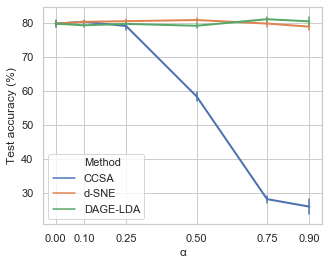

In [358]:
plt.figure(figsize=(5,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette("Set2")
# ax = sns.violinplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('A->D'), width=1)
# ax = sns.violinplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('W->A'), width=1)
# ax = sns.boxplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('A->D'), width=1)
# ax = sns.swarmplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('A->D'), size=6)
# ax = sns.swarmplot(x='Alpha', y='acc', hue='Method', data=get_alpha_search_results('W->A'), size=6)
# ax = sns.swarmplot(data=dsne_alpha_search_light_results, color=".25")
ax = sns.lineplot(x='Alpha', y='acc', hue='Method',err_style="bars", ci=68, data=get_alpha_search_results('A->D', True), linewidth=2)
# ax = sns.lineplot(x='Alpha', y='acc', hue='Method',err_style="bars", ci=68, data=get_alpha_search_results('W->A', True), linewidth=2)
# plt.xlabel('Relative weighting of domain adaptation loss versus cross-entropy loss (α)')
plt.xlabel('α')
plt.ylabel('Test accuracy (%)')
plt.xticks([0, 0.1, 0.25, 0.5, 0.75, 0.9])
plt.legend(loc='lower left')
# plt.ylim((60,74))
# plt.savefig('alpha-search-DA-line.pdf')  

### Batch size

In [512]:
def get_batch_size_results(datasets='A->D', linestyle='-'):
    def mod(df, bs:float, method:str, column=datasets):
        df = df[column].rename('acc').to_frame()
        df['Batch Size'] = bs
        df['Method'] = method
        df['Learning Rate'] = method
        df['line style'] = linestyle
        return df

    results = pd.concat([
        mod(ccsa_bs_16, 16, 'CCSA'),
        mod(ccsa_bs_64, 64, 'CCSA'),
        mod(ccsa_bs_256, 256, 'CCSA'),
        mod(ccsa_bs_1024, 1048, 'CCSA'),
        mod(ccsa_bs_4096, 4096, 'CCSA'),
        
        mod(dage_bs_16, 16, 'DAGE-LDA'),
        mod(dage_bs_64, 64, 'DAGE-LDA'),
        mod(dage_bs_256, 256, 'DAGE-LDA'),
        mod(dage_bs_1024, 1048, 'DAGE-LDA'),
        mod(dage_bs_4096, 4096, 'DAGE-LDA'),
        
        mod(ccsa_bs_16, 16, 'CCSA (comp)'),
        mod(ccsa_bs_64_comp, 64, 'CCSA (comp)'),
        mod(ccsa_bs_256_comp, 256, 'CCSA (comp)'),
        mod(ccsa_bs_1024_comp, 1048, 'CCSA (comp)'),
        mod(ccsa_bs_4096_comp, 4096, 'CCSA (comp)'),
        
        mod(dage_bs_16, 16, 'DAGE-LDA (comp)'),
        mod(dage_bs_64_comp, 64, 'DAGE-LDA (comp)'),
        mod(dage_bs_256_comp, 256, 'DAGE-LDA (comp)'),
        mod(dage_bs_1024_comp, 1048, 'DAGE-LDA (comp)'),
        mod(dage_bs_4096_comp, 4096, 'DAGE-LDA (comp)'),
    ])
                
    return results

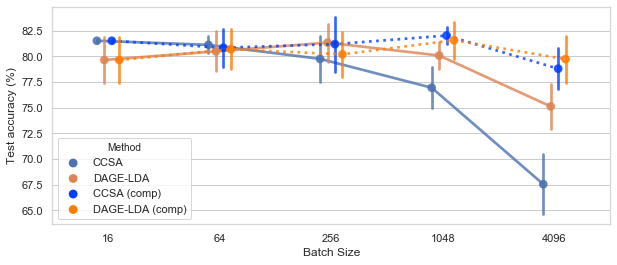

In [570]:
plt.figure(figsize=(10,4))
sns.set()
sns.set_style("whitegrid")
# sns.set_palette(sns.color_palette(None, 2))
ax = sns.pointplot(x='Batch Size', y='acc', hue='Method', dodge=0.2, data=get_batch_size_results('A->D'), ci='sd', linewidth=1, 
#                    linestyles=[':',':','-','-'], 
                   linestyles=['-','-',':',':'], 
                   palette=[*sns.color_palette('deep', 2), *sns.color_palette('bright', 2)])
# ax = sns.violinplot(x='Batch Size', y='acc', hue='Method', kind="point", data=get_batch_size_results('A->D'))
# ax = sns.lineplot(x='Batch Size', y='acc', hue='Method', err_style="bars", ci=68, data=get_batch_size_results('A->D'))
plt.setp(ax.get_children(),alpha=.8)
plt.xlabel('Batch Size')
plt.ylabel('Test accuracy (%)')
ax.figsize=(10,4)

# plt.xticks([16, 64, 254, 1024, 4096])
# plt.legend(loc='lower left')
# plt.ylim((60,74))
plt.savefig('batch_size-AD-line.pdf') 


# Utils

In [ ]:
# restructure former runs
def reorganize(from_date, to_date, suffix, experiment_id='your_id', description='your_description_here'):

    RUNS_DIR_OLD = RUNS_DIR / '..' / 'runs_old'

    for item in RUNS_DIR_OLD.glob('*'):
        parts = item.name.split('_')
        if len(parts)<3:
            continue
        timestamp = parts[0]
        src = parts[1]
        tgt = parts[2]
        method = '_'.join(parts[3:])
        
        if (item.is_dir() 
            and item.name.endswith(suffix)
            and int(item.name.split('_')[0]) >= int(from_date)
            and int(item.name.split('_')[0]) <= int(to_date)):

            seed = load_json(item / 'config.json')['seed']

            new_method_dir = RUNS_DIR / method / experiment_id 
            new_run_dir = new_method_dir / '{}{}_{}_{}'.format(src,tgt,seed,timestamp)
            
            try:
                shutil.copytree(item, new_run_dir)
            except:
                pass
            
            new_run_dir.mkdir(parents=True, exist_ok=True)

            with open(new_method_dir / 'description.txt', 'a') as f:
                f.write(description)


In [ ]:
# reorganize(
#     from_date='20191014123846',
#     to_date='20191014162536',
#     suffix='tune_source',
#     experiment_id='tune_source_no_aug',
#     description='In this experiment, we tune a VGG16-network pretrained on ImageNet with all available source data. The target data is used for validation (during training) and test. No augmentation was used'
# )

# reorganize(
#     from_date='20191022103424',
#     to_date='20191022142437',
#     suffix='tune_source',
#     experiment_id='tune_source_with_aug',
#     description='In this experiment, we tune a VGG16-network pretrained on ImageNet with all available source data. The target data is used for validation (during training) and test. Augmentation was used'
# )

# reorganize(
#     from_date='20191023072318',
#     to_date='20191023123426',
#     suffix='tune_target',
#     experiment_id='tune_target_with_aug',
#     description='Fine tune target from ImageNet model that was already fine-tuned on source. Augmentation was used. No batchnorm was used.'
# )

# reorganize(
#     from_date='20191025141713',
#     to_date='20191025170306',
#     suffix='ccsa',
#     experiment_id='ccsa_without_batchnorn',
#     description='CCSA method without batchnorm. In this experiment, we saw stability issues for loss_alpha over 0.01.'
# )

# reorganize(
#     from_date='20191101173414',
#     to_date='20191101191220',
#     suffix='ccsa',
#     experiment_id='ccsa_with_batchnorn_alpha_0',
#     description='CCSA method with batchnorm and loss_alpha=0. This amounts to a multi-task learning setup.'
# )

# reorganize(
#     from_date='20191101150707',
#     to_date='20191101171905',
#     suffix='ccsa',
#     experiment_id='ccsa_with_batchnorn_alpha_0.25',
#     description='CCSA method with batchnorm and loss_alpha=0.25.'
# )

# reorganize(
#     from_date='20191104152050',
#     to_date='20191104185818',
#     suffix='ccsa',
#     experiment_id='ccsa_uneven',
#     description='CCSA method with batchnorm and loss_alpha=0.25. Here, we only weight the target softmax (source softmax not used).'
# )

# reorganize(
#     from_date='20191106083058',
#     to_date='20191106144631',
#     suffix='ccsa',
#     experiment_id='ccsa_resnet_uneven',
#     description='CCSA method with batchnorm and loss_alpha=0.25. Here, we only weight the target softmax (source softmax not used). ResNet features where used.'
# )

# reorganize(
#     from_date='20191104094606',
#     to_date='20191104124943',
#     suffix='dsne',
#     experiment_id='dsne_even',
#     description='DSNE method using both source and target softmax loss'
# )

# reorganize(
#     from_date='20191104152038',
#     to_date='20191104182550',
#     suffix='dsne',
#     experiment_id='dsne_uneven',
#     description='DSNE method using only target softmax loss'
# )

# reorganize(
#     from_date='20191105120356',
#     to_date='20191105154214',
#     suffix='dsne',
#     experiment_id='dsne_uneven_large',
#     description='DSNE method using only target softmax loss. Larger dimensionality was used for dense and embedding layers'
# )

# reorganize(
#     from_date='20191107085855',
#     to_date='20191107131237',
#     suffix='dsne',
#     experiment_id='dsne_uneven_resnet',
#     description='DSNE method using only target softmax loss. ResNet features where used.'
# )

# reorganize(
#     from_date='20191113093959',
#     to_date='20191113143542',
#     suffix='homebrew',
#     experiment_id='dage_uneven_resnet',
#     description='DAGE method using only target softmax loss. ResNet features where used.'
# )